# Data Validation of Downtown Bluetooth Readings

## Directional Mismatch
Replication of @radumas earlier analysis of directional mismatch on the Gardiner. 

Notes: BT sensor at King/Spadina was down during Oct.17 to Oct.31 resulting in missing data for that intersection.
Some directional mismatch should be expected.
### Questions to Answer
 - Is detection biased in any direction?
 - Is there a detection rate difference between E/W vs N/S?

In [3]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
from datetime import datetime, timedelta, date
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import pandas as pd
import pandas.io.sql as pandasql
import seaborn as sns
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [4]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [3]:
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional')
direction_obs = pandasql.read_sql(sql, con)

NOTE: Oneway streets are ommitted from the `ryu4.aggr_bt_directional` table. Values produced by the chart are from the entirety of September and October

### Confirming Imbalance

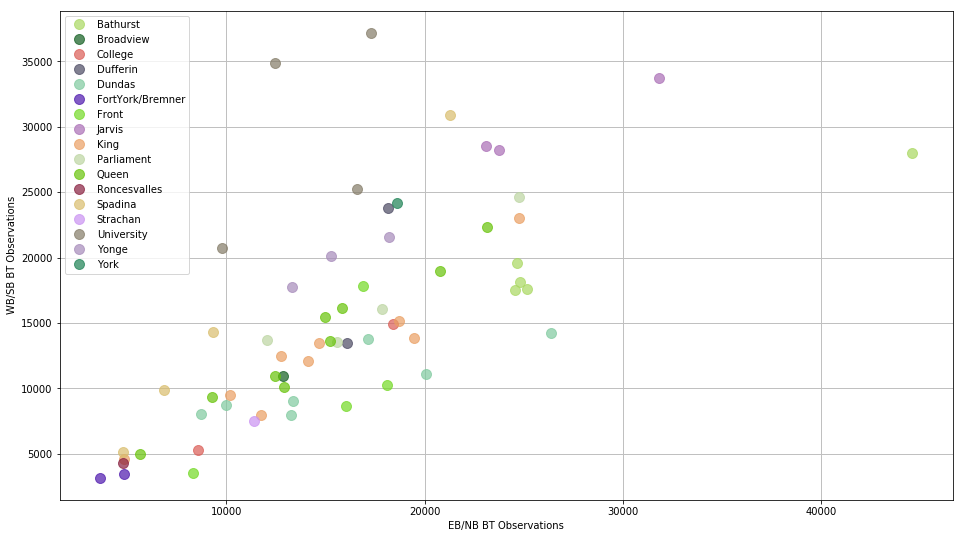

In [4]:
groups = direction_obs.groupby('street')
colours = np.random.rand(len(groups), 3,)
colour_cycle = cycle(colours)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.grid(color='silver', linestyle='-', linewidth=1)
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')

for i, (street, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=street, linestyle='', color=next(colour_cycle))
plt.legend()
plt.show()

The scatterplot shows WB/SB observations of a route compared to their repsective EB/NB BT observations. As you can see, a few of the routes aren't 1:1.

In [5]:
sql = '''SELECT d.sb_wb_report_name AS "WB/SB Route Name", \
        d.nb_eb_report_name AS "EB/NB Route Name", \
        d.eb_nb_obs AS "Number EB/NB obs", \
        d.wb_sb_obs AS "Number WB/SB obs", \
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "EB/WB NB/SB Ratio",
        CASE
            WHEN rp.direction = 'EBWB' THEN CASE
                                            WHEN d.eb_nb_obs < d.wb_sb_obs THEN 'WB'
                                            WHEN d.eb_nb_obs > d.wb_sb_obs THEN 'EB'
                                            END
            WHEN rp.direction = 'NBSB' THEN CASE
                                            WHEN d.eb_nb_obs < d.wb_sb_obs THEN 'SB'
                                            WHEN d.eb_nb_obs > d.wb_sb_obs THEN 'NB'
                                            END
        END AS "Bias Towards"
        FROM ryu4.aggr_bt_directional d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        ORDER BY "EB/WB NB/SB Ratio" DESC;'''
print_table(sql, con)

The chart above shows each route's EB/NB and WB/SB observation counts for Sept-Oct in addition to EB/NB-WB/SB observations. All route observations are not 1:1 with both directions which is expected. However, these differences are fairly high for both directions and there are many factors which may be influencing them. Lowering the range and taking data that is more recent may produce better results.

### One-week focus

In [6]:
# select one week of data between '2017-10-25 00:00:00' and '2017-11-01 00:00:00'
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional_oneweek')
direction_obs_oneweek = pandasql.read_sql(sql, con)

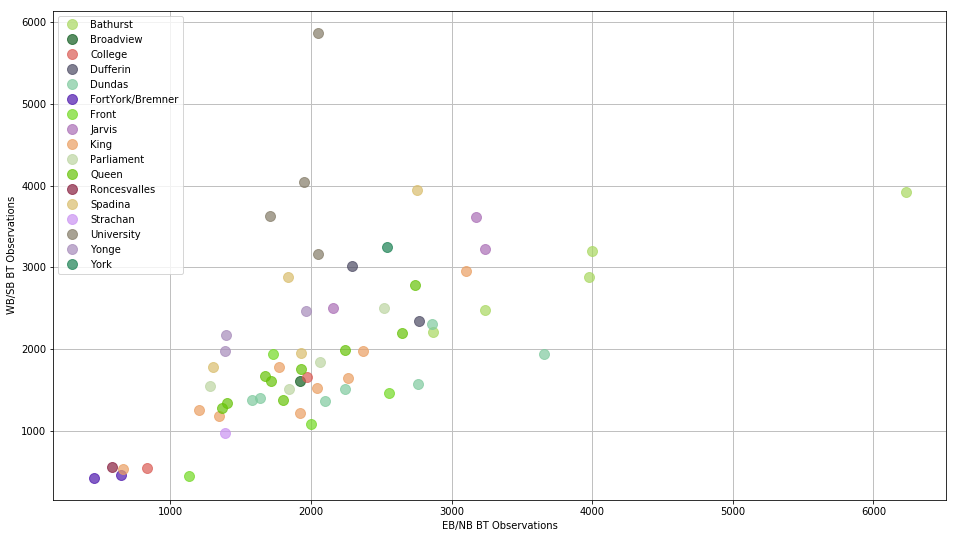

In [7]:
groups = direction_obs_oneweek.groupby('street')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.grid(color='silver', linestyle='-', linewidth=1)
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (street, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=street, linestyle='', color=next(colour_cycle))
plt.legend()
plt.show()

Not much has changed between the 2-month interval graph and the 1-week interval graph. Since not much has changed, a focus is given on the top/bottom routes with largest difference between EB/NB and WB/SB.

In [5]:
#EB/WB Observation ratios
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'EBWB'
        ORDER BY "ratio" DESC;'''
ebwb_obs = pandasql.read_sql(sql, con)
#NB/SB Observation ratios
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'NBSB'
        ORDER BY "ratio" DESC;'''
nbsb_obs = pandasql.read_sql(sql, con)
#EB Observation ratio
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'EBWB' AND d.eb_nb_obs > d.wb_sb_obs
        ORDER BY "ratio" DESC;'''
eb_bias_obs = pandasql.read_sql(sql, con)
#WB Observation ratio
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'EBWB' AND d.eb_nb_obs < d.wb_sb_obs
        ORDER BY "ratio" DESC;'''
wb_bias_obs = pandasql.read_sql(sql, con)
#NB Observation ratio
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'NBSB' AND d.eb_nb_obs > d.wb_sb_obs
        ORDER BY "ratio" DESC;'''
nb_bias_obs = pandasql.read_sql(sql, con)
#SB Observation ratio
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN (d.eb_nb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN (d.wb_sb_obs * 1.0) / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'NBSB' AND d.eb_nb_obs < d.wb_sb_obs
        ORDER BY "ratio" DESC;'''
sb_bias_obs = pandasql.read_sql(sql, con)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2081: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:2082: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


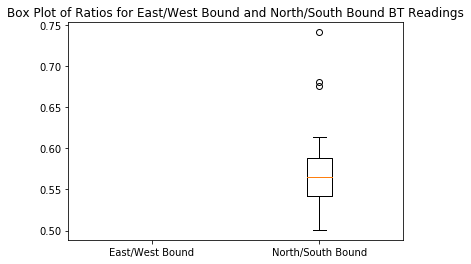

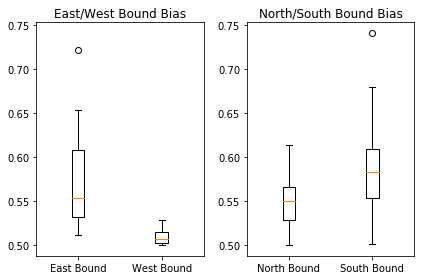

In [6]:
# Box plot comparing EB/WB vs NB/SB ratios
data = [ebwb_obs, nbsb_obs]
plt.subplot(1,1,1)
plt.boxplot(data)
plt.xticks([1,2],['East/West Bound', 'North/South Bound'])
plt.title("Box Plot of Ratios for East/West Bound and North/South Bound BT Readings")
plt.show()

# Box plots comparing EB vs WB and NB vs SB ratios
data = [eb_bias_obs, wb_bias_obs]
ax1 = plt.subplot(121)
plt.boxplot(data)
plt.xticks([1,2],['East Bound', 'West Bound'])
plt.title("East/West Bound Bias")
data = [nb_bias_obs, sb_bias_obs]
ax2 = plt.subplot(122, sharey=ax1)
plt.boxplot(data)
plt.xticks([1,2],['North Bound', 'South Bound'])
plt.title("North/South Bound Bias")
plt.tight_layout()
plt.show()

As shown by the first plot, the magnitude and number of imbalanced E/W bound and N/S bound are roughly similar with N/S bound containing two outliers. These outliers are 'University Queen/Dundas' and 'University Dundas/College' which have a higher imbalanced ratio than other routes. Comparing these two boxplots, it can't be determined if there is a considerable difference between imbalanced E/W bound and N/S bound routes.

The secondary graphs show the magnitude of the direction the observations are biased towards. For E/W, the observations on the sensors are more biased towards east bound traffic than westbound. For N/W, observations are more bias towards south bound traffic.

In [10]:
sql = '''SELECT sb_wb_report_name AS "wbsb_route", \
        nb_eb_report_name AS "ebnb_route" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY eb_nb_obs - wb_sb_obs;'''
routes = pandasql.read_sql(sql, con)
ebnb_route = routes.ebnb_route
wbsb_route = routes.wbsb_route

Day of Week Plots for BT Observations


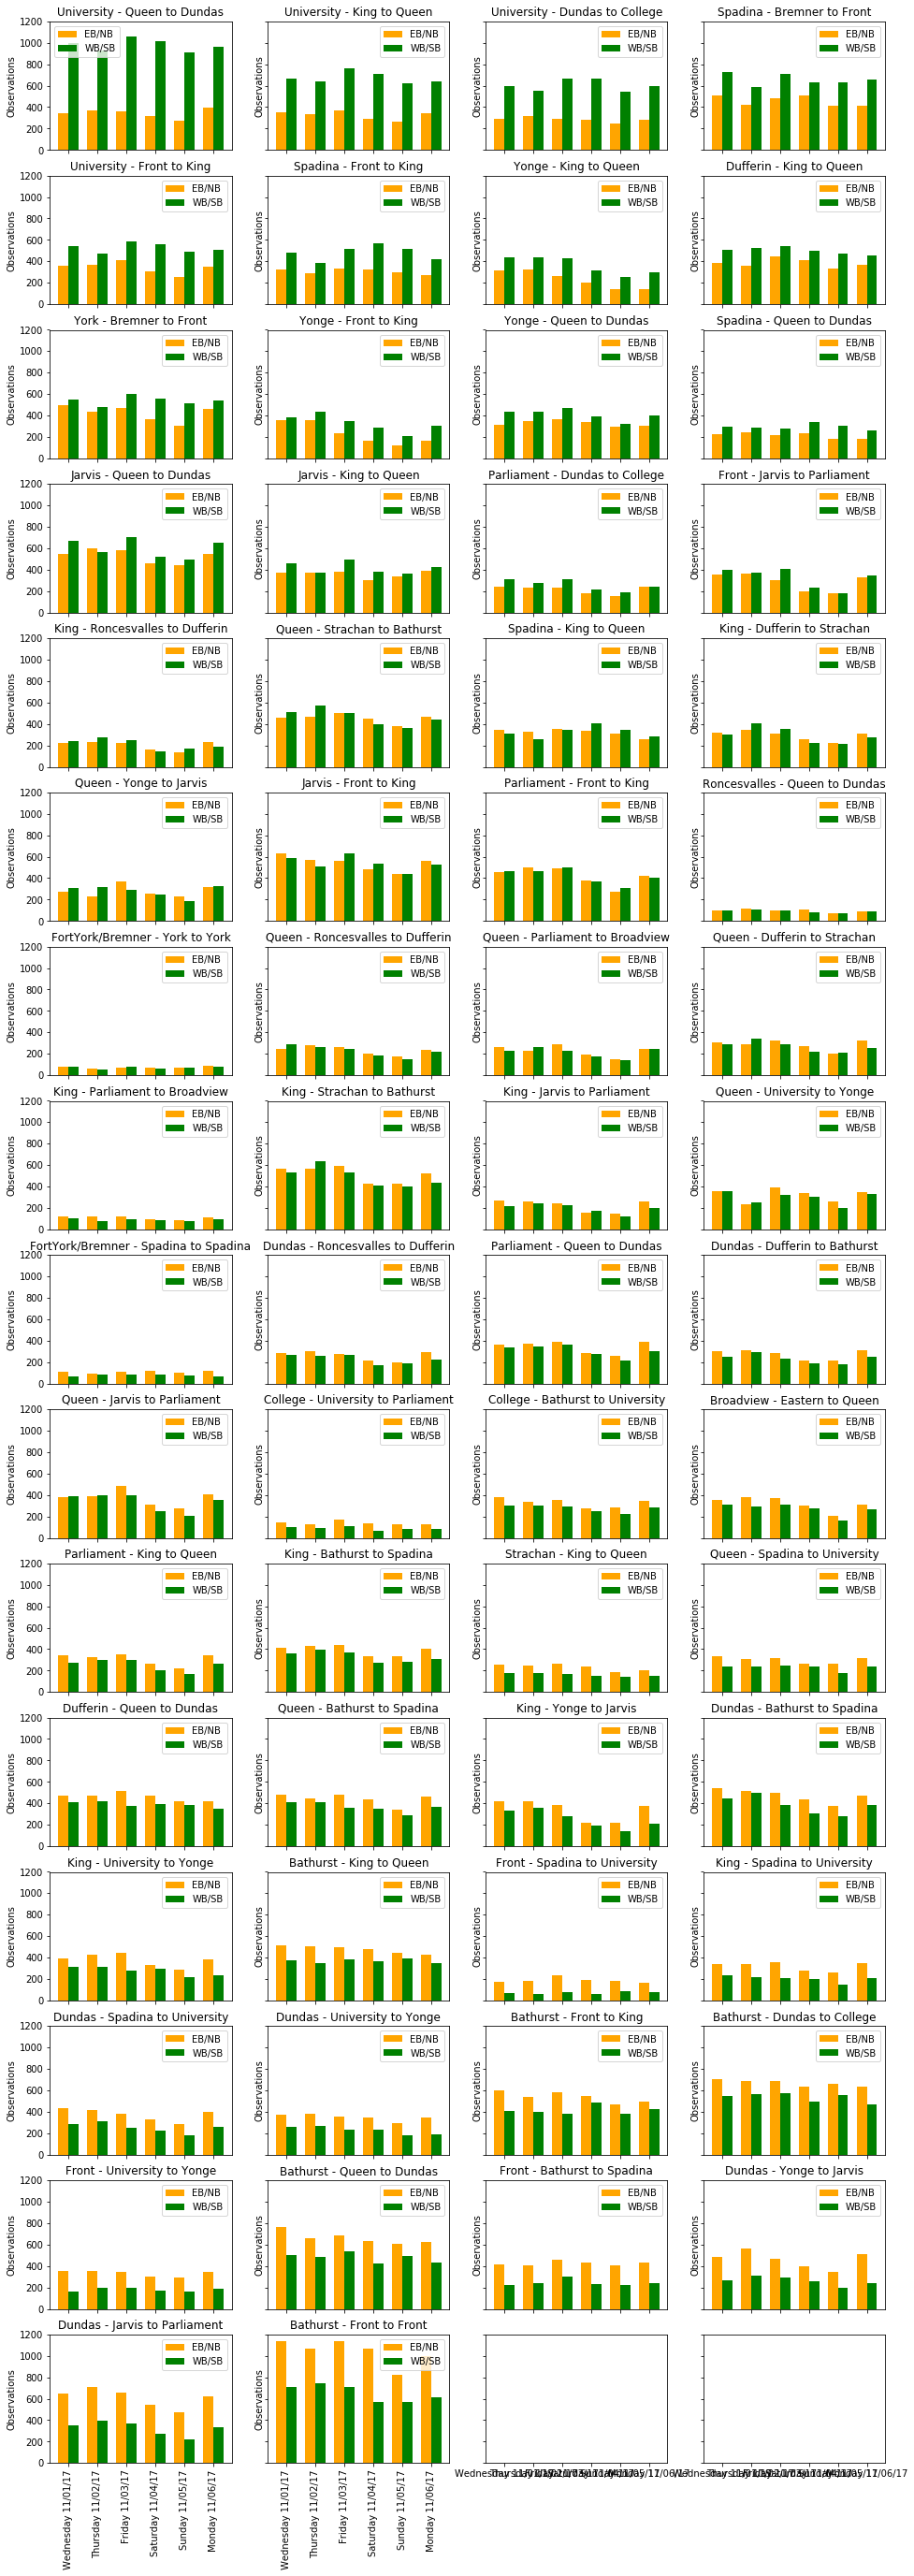

In [11]:
# setting up 16 x 4 facet grid for day of week plots
# Note: There are only 62 routes, so there are 2 empty plots
fig, ax = plt.subplots(nrows=16, ncols=4, sharex= True, sharey= True, figsize=(16,48))
row, col = 0, 0 
for i in range(len(routes)):
    sql = pg.SQL('''SELECT eb_nb_obs, wb_sb_obs, date_bin, street, from_street, to_street \
            FROM ryu4.aggr_bt_directional_day \
            WHERE nb_eb_report_name = {ebnb_route} AND sb_wb_report_name = {wbsb_route}
            ORDER BY date_bin''').format(ebnb_route = pg.Literal(ebnb_route[i]), wbsb_route = pg.Literal(wbsb_route[i]))
    route_obs_day = pandasql.read_sql(sql, con)
    # setting up dual bar graphs
    N = len(route_obs_day)
    ind = np.arange(N)
    width = 0.35
    ebnb_rects = ax[row,col].bar(ind, route_obs_day.eb_nb_obs, width, color='orange')
    wbsb_rects = ax[row,col].bar(ind + width, route_obs_day.wb_sb_obs, width, color='green')
    ax[row,col].set_ylabel('Observations')
    ax[row,col].set_title(route_obs_day.street[0] + ' - ' + 
                          route_obs_day.from_street[0] + ' to ' +
                          route_obs_day.to_street[0])
    ax[row,col].set_xticks(ind + width / 2)
    ax[row,col].set_xticklabels([date.strftime("%A %x") for date in route_obs_day.date_bin], rotation=90)
    ax[row,col].legend((ebnb_rects[0], wbsb_rects[0]), ('EB/NB', 'WB/SB'))
    col += 1
    if col%4 == 0: 
        row += 1
        col  = 0
print('Day of Week Plots for BT Observations')
plt.show()

In [3]:
sql = '''SELECT sb_wb_report_name AS "wbsb_route", \
        nb_eb_report_name AS "ebnb_route" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY CASE
            WHEN eb_nb_obs > wb_sb_obs THEN (eb_nb_obs * 1.0) / (eb_nb_obs + wb_sb_obs)
            WHEN eb_nb_obs < wb_sb_obs THEN (wb_sb_obs * 1.0) / (eb_nb_obs + wb_sb_obs)
        END DESC;'''
routes = pandasql.read_sql(sql, con)
ebnb_route = routes.ebnb_route
wbsb_route = routes.wbsb_route

DT-0025. Queen-EB_Yonge-to-Jarvis / DT-0030. Queen-WB_Jarvis-to-Yonge


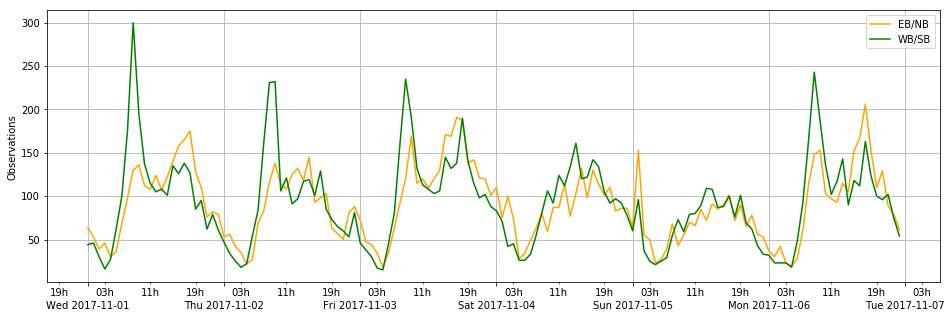

DT-0117. University-NB_Queen-to-Dundas / DT-0110. University-SB_Dundas-to-Queen


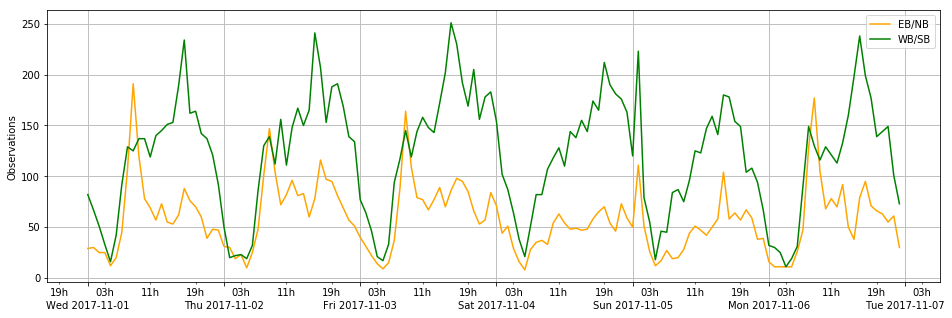

DT-0071. Front-EB_Spadina-to-University / DT-0077. Front-WB_University-to-Spadina


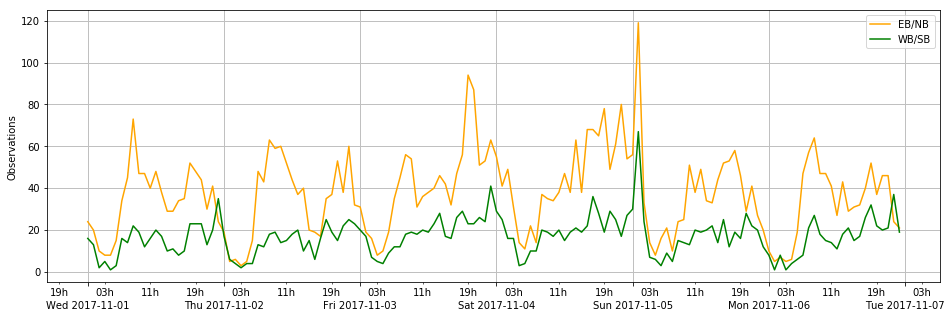

DT-0118. University-NB_Dundas-to-College / DT-0109. University-SB_College-to-Dundas


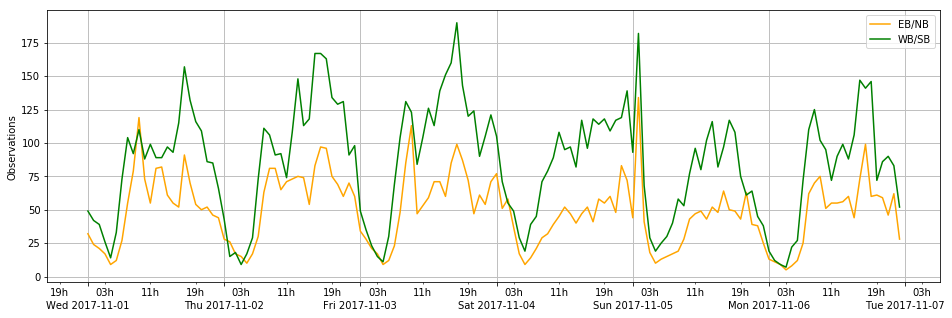

DT-0116. University-NB_King-to-Queen / DT-0111. University-SB_Queen-to-King


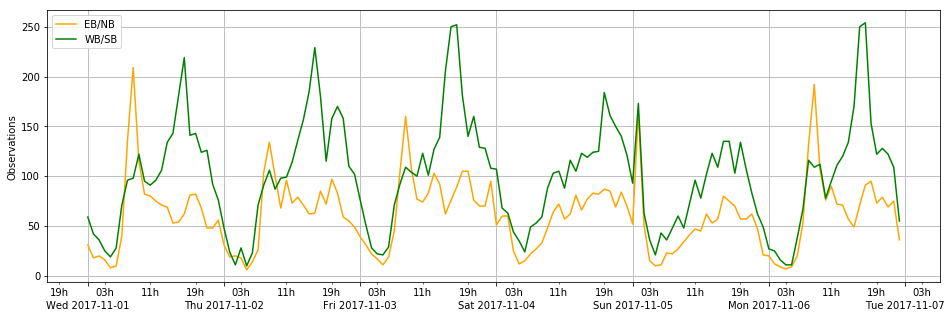

DT-0011. Dundas-EB_Jarvis-to-Parliament / DT-0012. Dundas-WB_Parliament-to-Jarvis


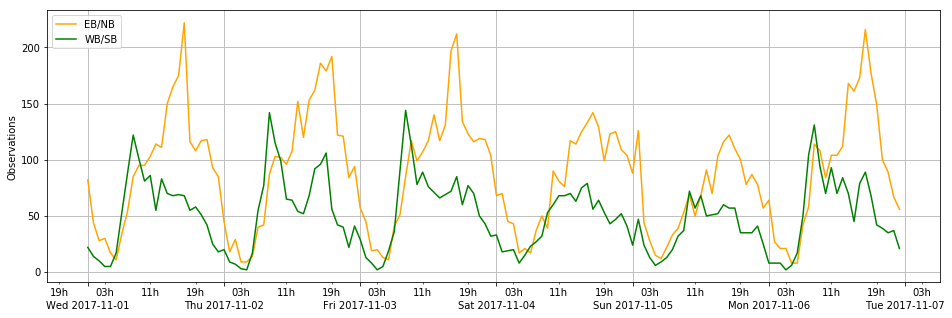

DT-0072. Front-EB_University-to-Yonge / DT-0076. Front-WB_Yonge-to-University


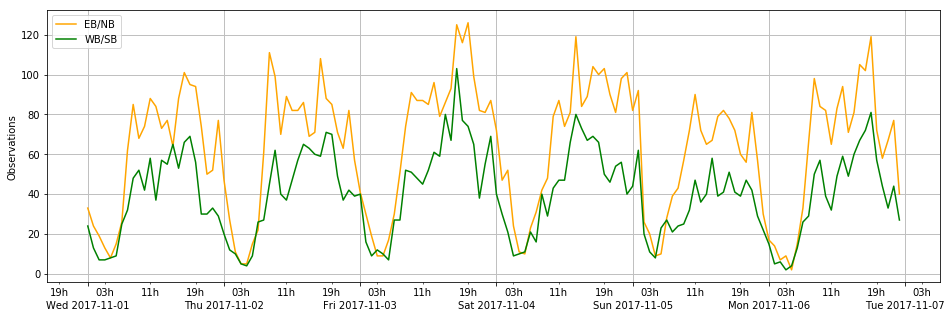

DT-0010. Dundas-EB_Yonge-to-Jarvis / DT-0013. Dundas-WB_Jarvis-to-Yonge


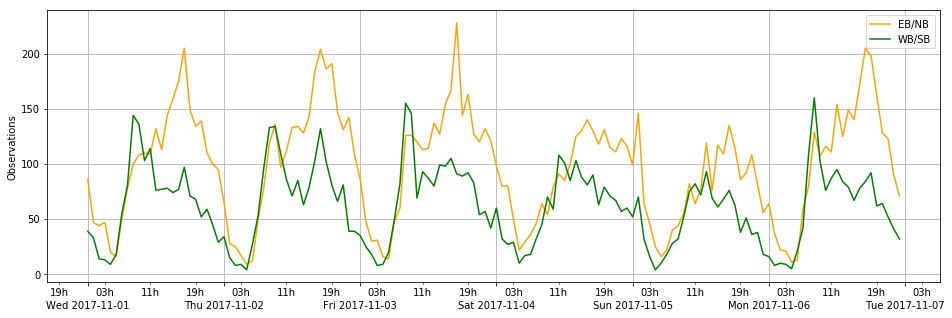

DT-0070. Front-EB_Bathurst-to-Spadina / DT-0078. Front-WB_Spadina-to-Bathurst


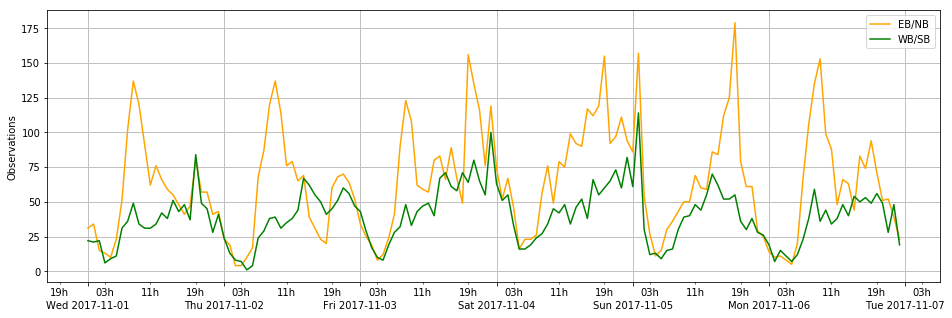

DT-0096. Bathurst-NB_FortYork-to-Front / DT-0095. Bathurst-SB_Front-to-FortYork


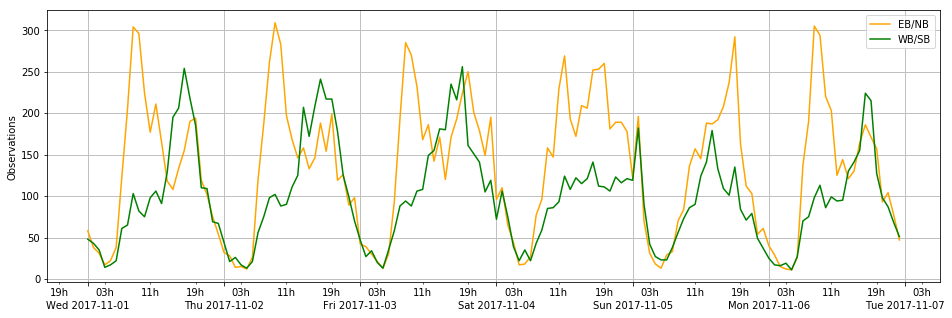

DT-0053. King-EB_Spadina-to-University / DT-0062. King-WB_University-to-Spadina


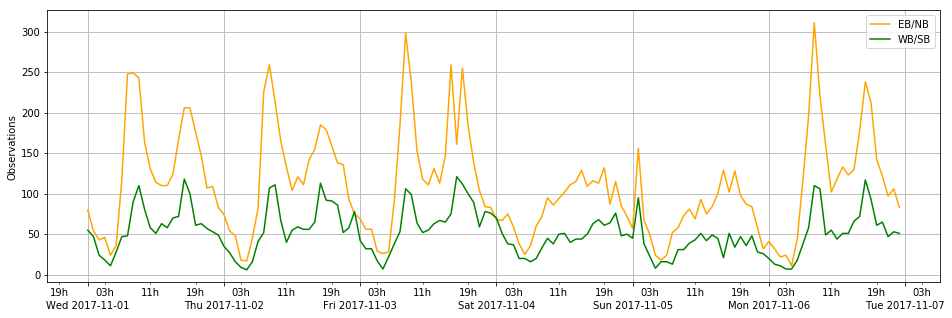

DT-0106. Spadina-NB_Front-to-King / DT-0103. Spadina-SB_King-to-Front


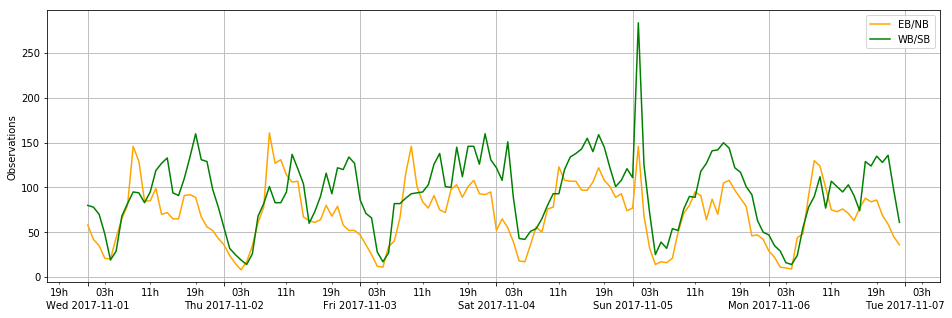

DT-0123. Yonge-NB_King-to-Queen / DT-0120. Yonge-SB_Queen-to-King


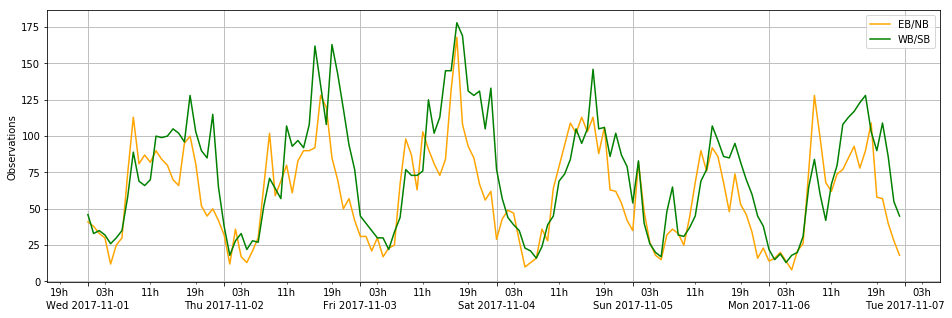

DT-0002. College-EB_University-to-Parliament / DT-0003. College-WB_Parliament-to-University


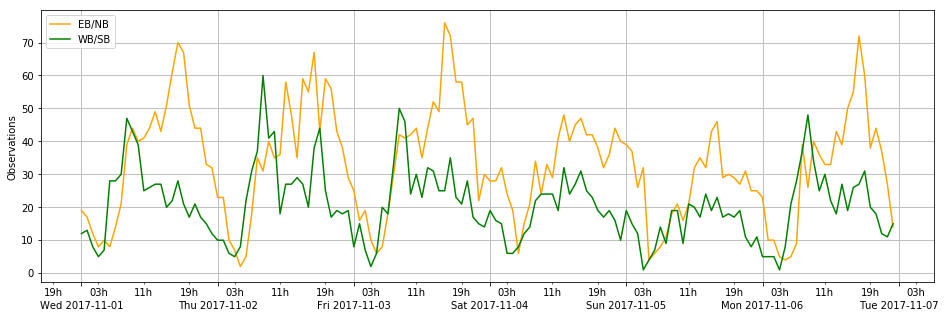

DT-0009. Dundas-EB_University-to-Yonge / DT-0014. Dundas-WB_Yonge-to-University


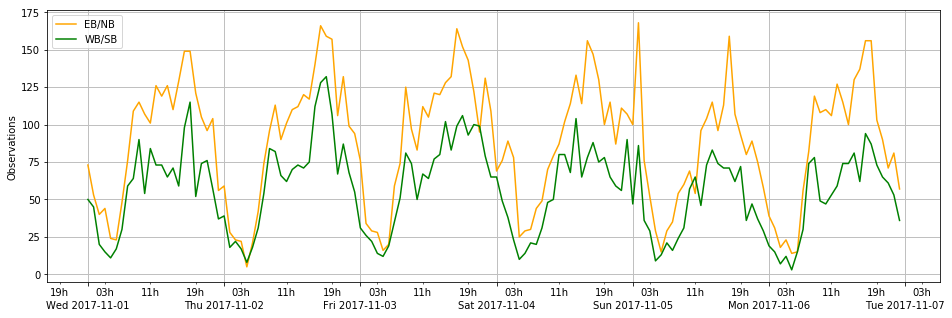

DT-0115. University-NB_Front-to-King / DT-0112. University-SB_King-to-Front


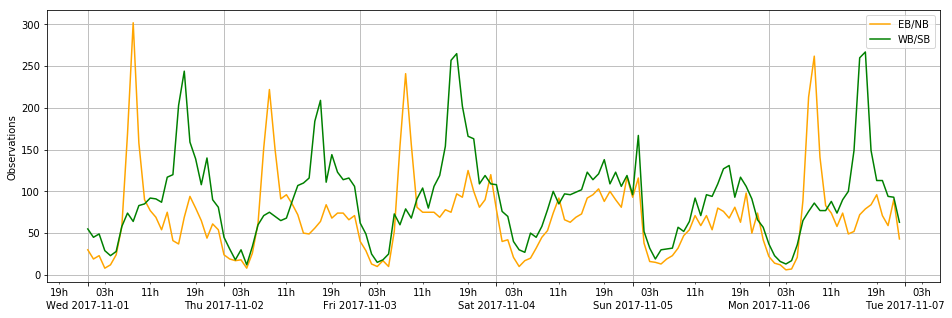

DT-0008. Dundas-EB_Spadina-to-University / DT-0015. Dundas-WB_University-to-Spadina


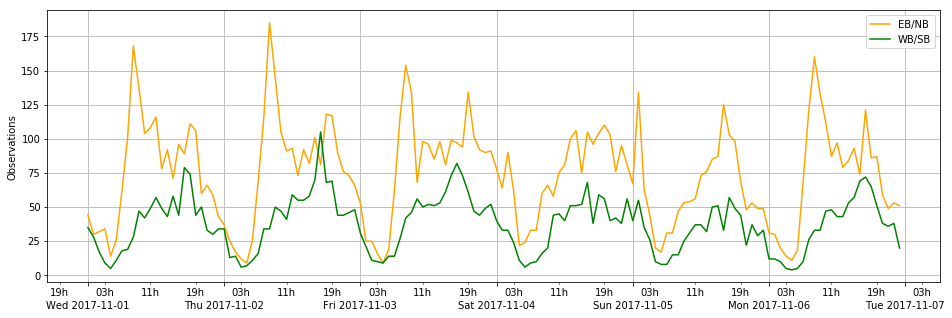

DT-0105. Spadina-NB_Bremner-to-Front / DT-0104. Spadina-SB_Front-to-Bremner


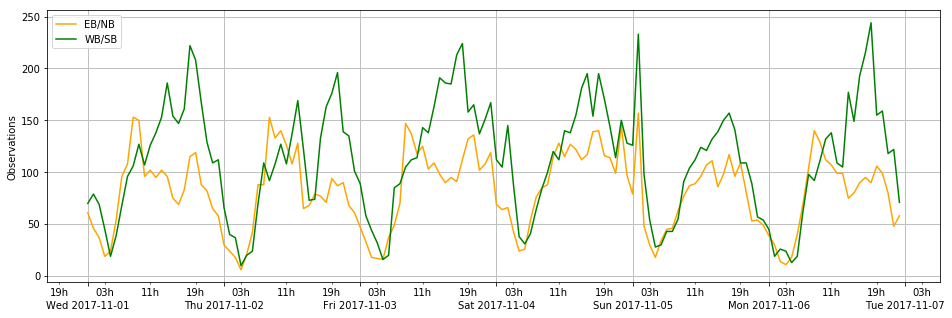

DT-0090. Strachan-NB_King-to-Queen / DT-0089. Strachan-SB_Queen-to-King


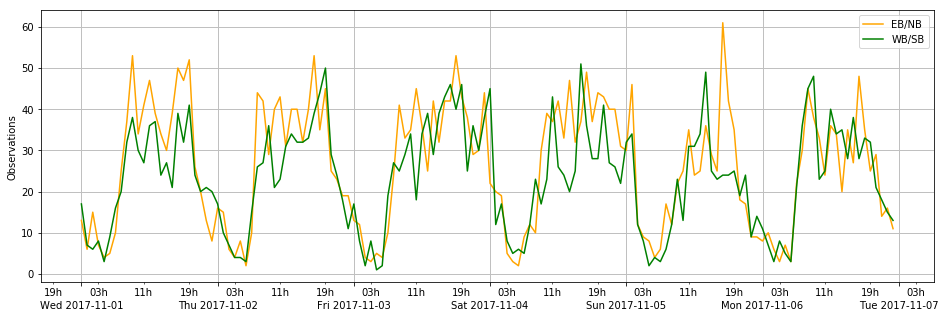

DT-0122. Yonge-NB_Front-to-King / DT-0121. Yonge-SB_King-to-Front


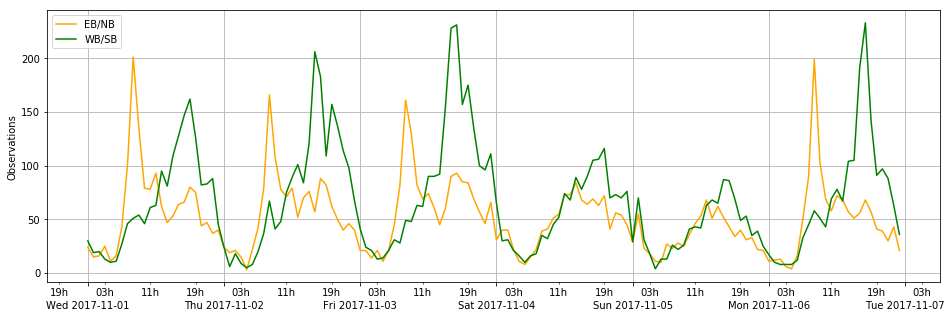

DT-0079. FortYork/Bremner-EB_Bathurst-to-Spadina / DT-0082. FortYork/Bremner-WB_Spadina-to-Bathurst


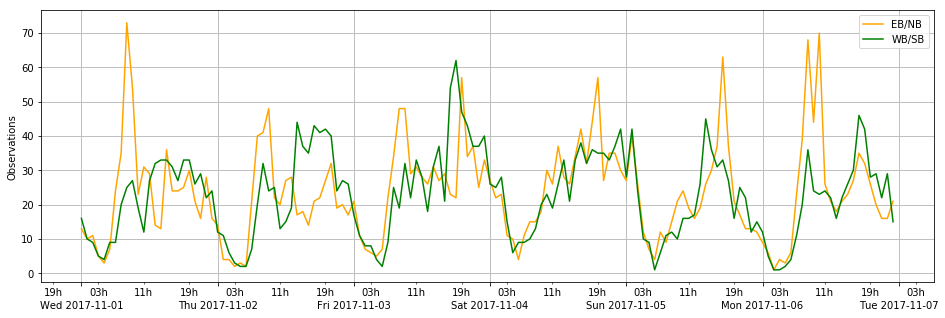

DT-0099. Bathurst-NB_Queen-to-Dundas / DT-0092. Bathurst-SB_Dundas-to-Queen


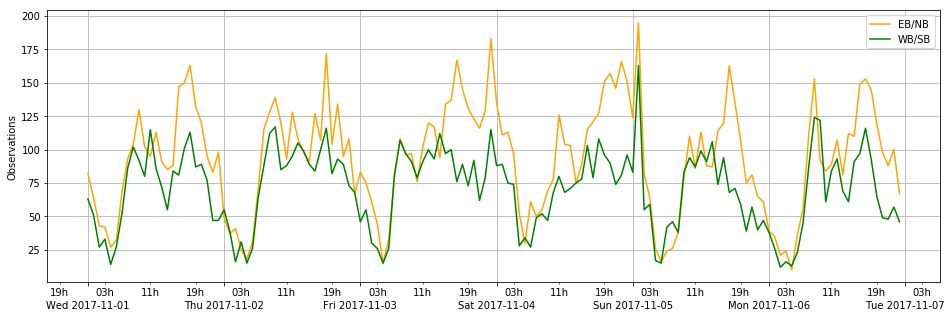

DT-0054. King-EB_University-to-Yonge / DT-0061. King-WB_Yonge-to-University


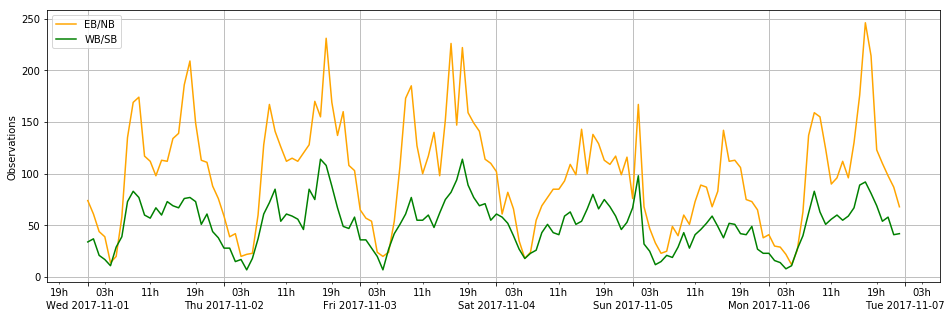

DT-0108. Spadina-NB_Queen-to-Dundas / DT-0101. Spadina-SB_Dundas-to-Queen


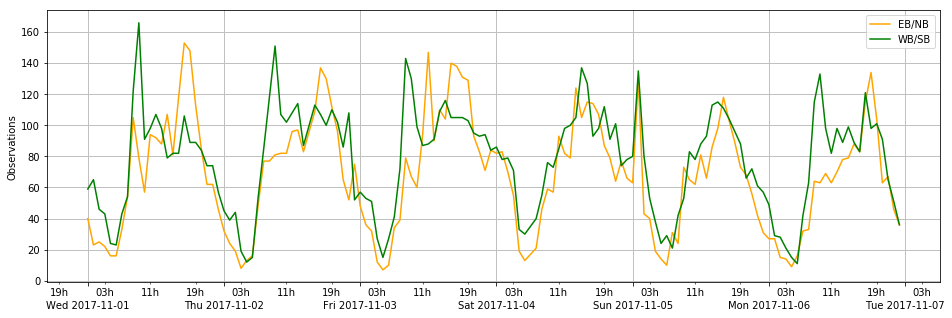

DT-0055. King-EB_Yonge-to-Jarvis / DT-0060. King-WB_Jarvis-to-Yonge


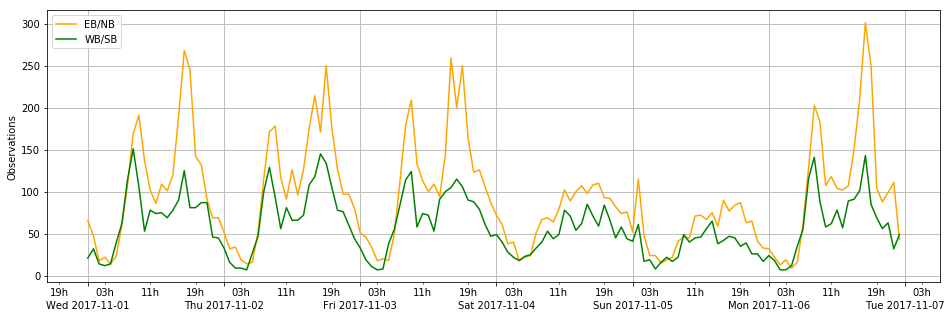

DT-0087. Dufferin-NB_King-to-Queen / DT-0086. Dufferin-SB_Queen-to-King


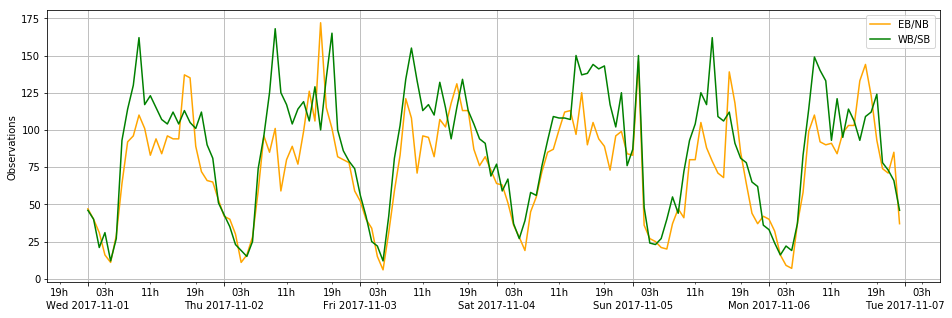

DT-0097. Bathurst-NB_Front-to-King / DT-0094. Bathurst-SB_King-to-Front


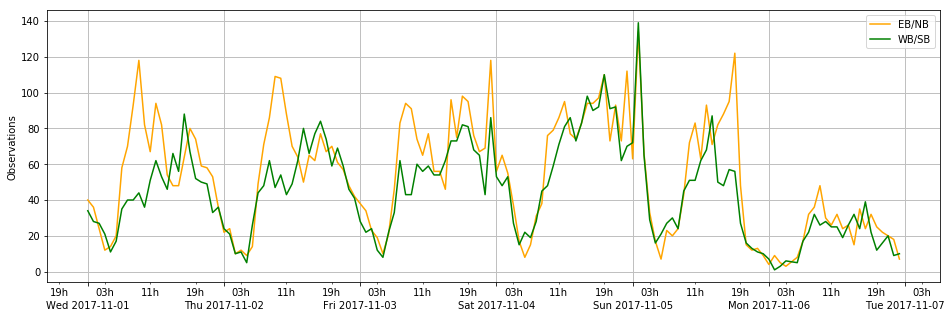

DT-0023. Queen-EB_Spadina-to-University / DT-0032. Queen-WB_University-to-Spadina


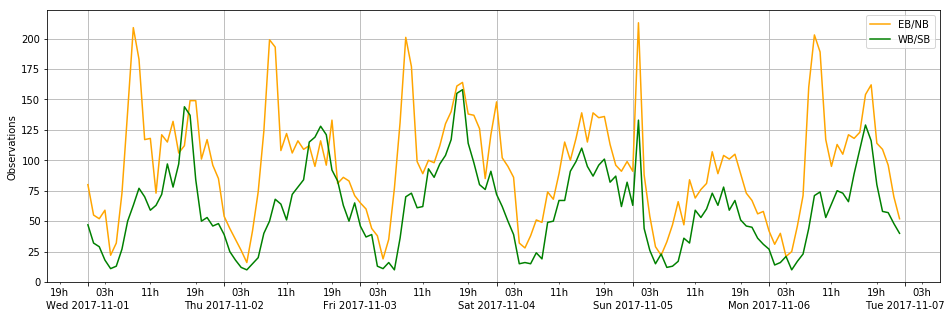

DT-0098. Bathurst-NB_King-to-Queen / DT-0093. Bathurst-SB_Queen-to-King


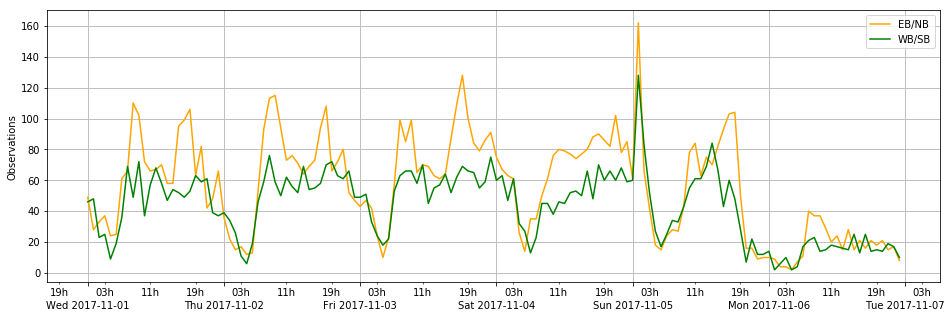

DT-0114. York-NB_Bremner-to-Front / DT-0113. York-SB_Front-to-Bremner


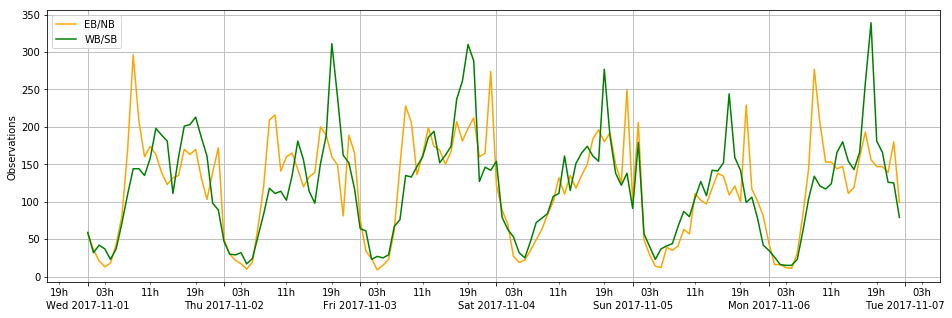

DT-0124. Yonge-NB_Queen-to-Dundas / DT-0119. Yonge-SB_Dundas-to-Queen


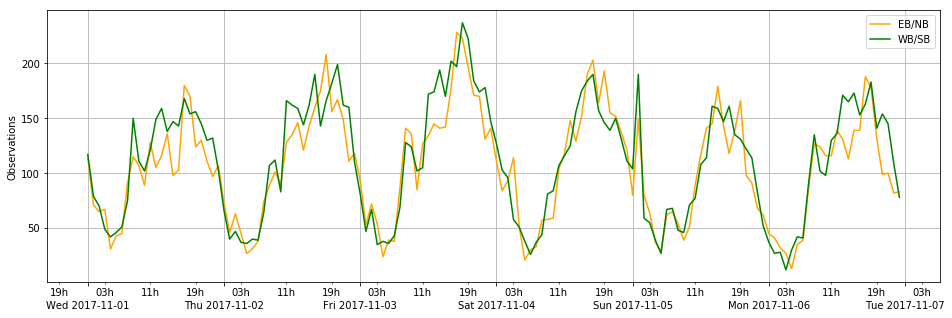

DT-0100. Bathurst-NB_Dundas-to-College / DT-0091. Bathurst-SB_College-to-Dundas


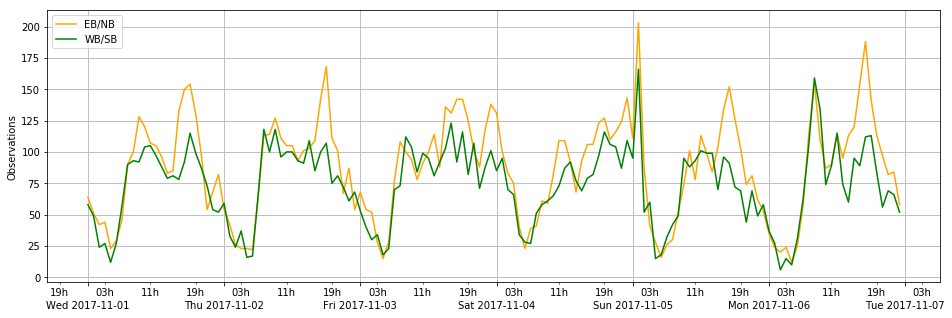

DT-0057. King-EB_Parliament-to-Broadview / DT-0058. King-WB_Broadview-to-Parliament


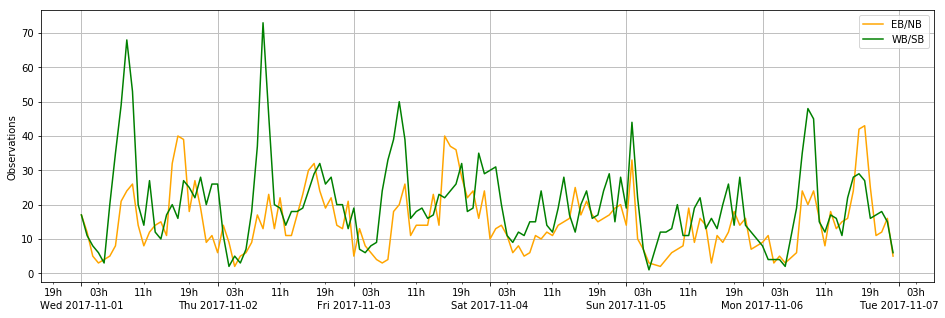

DT-0007. Dundas-EB_Bathurst-to-Spadina / DT-0016. Dundas-WB_Spadina-to-Bathurst


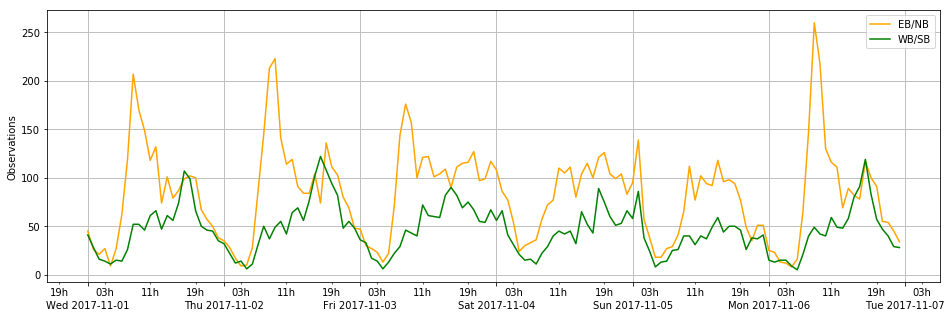

DT-0136. Parliament-NB_King-to-Queen / DT-0133. Parliament-SB_Queen-to-King


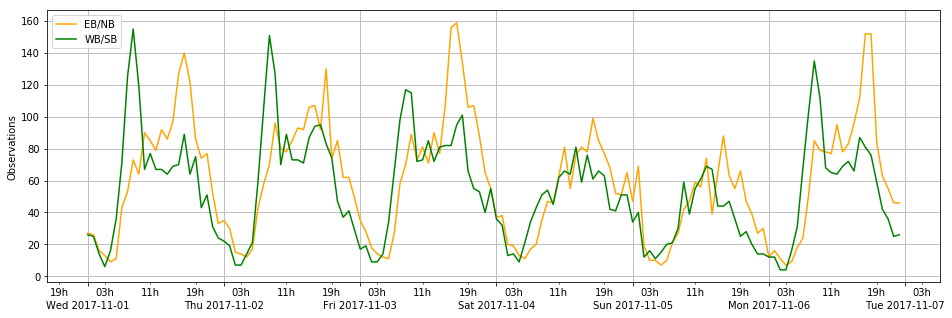

DT-0022. Queen-EB_Bathurst-to-Spadina / DT-0033. Queen-WB_Spadina-to-Bathurst


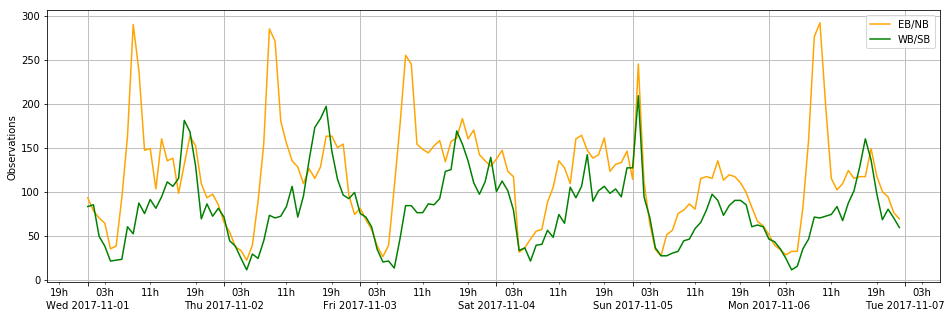

DT-0138. Parliament-NB_Dundas-to-College / DT-0131. Parliament-SB_College-to-Dundas


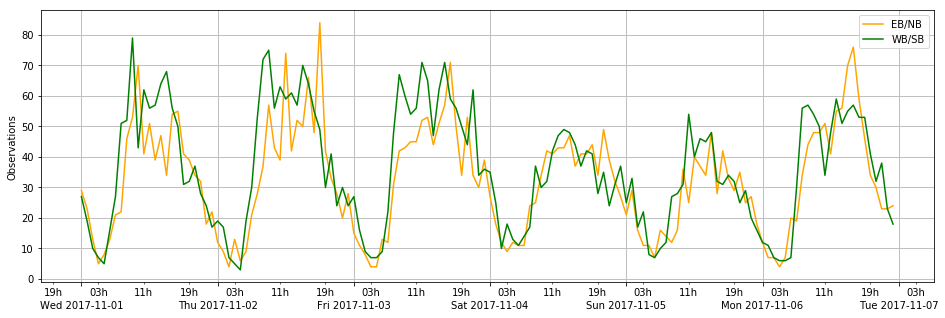

DT-0052. King-EB_Bathurst-to-Spadina / DT-0063. King-WB_Spadina-to-Bathurst


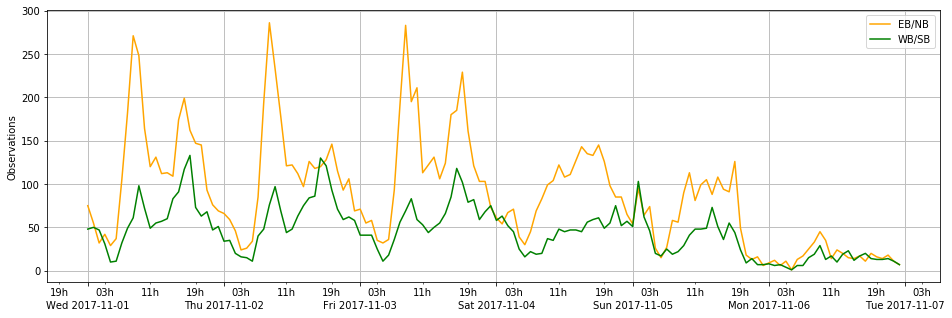

DT-0140. Broadview-NB_Eastern-to-Queen / DT-0139. Broadview-SB_Queen-to-Eastern


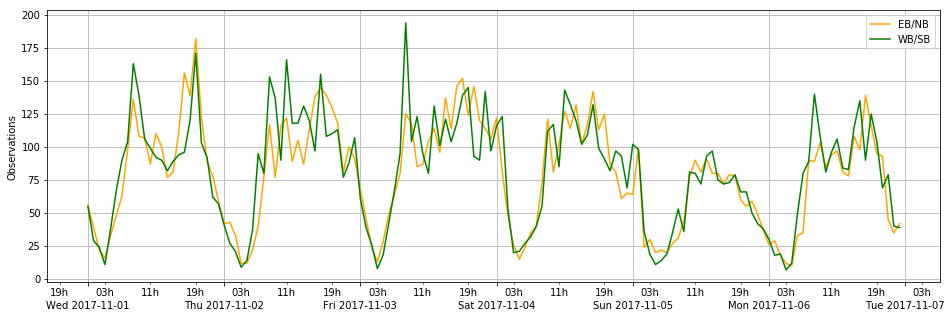

DT-0001.College-EB_Bathurst-to-University / DT-0004. College-WB_University-to-Bathurst


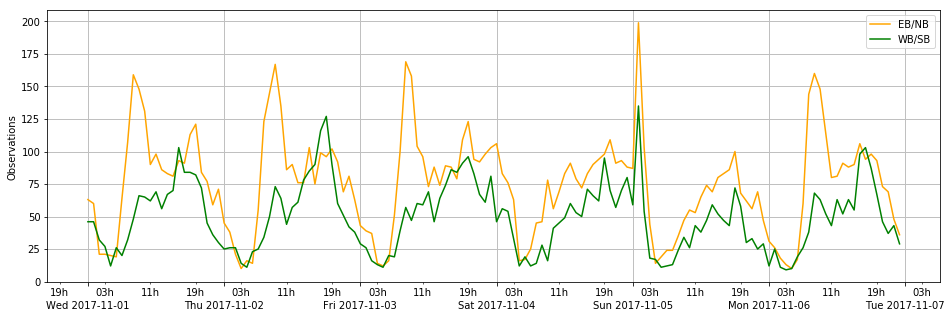

DT-0088. Dufferin-NB_Queen-to-Dundas / DT-0085. Dufferin-SB_Dundas-to-Queen


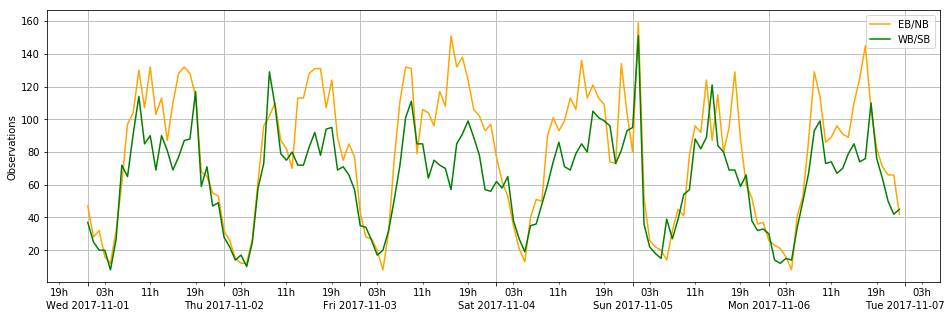

DT-0006. Dundas-EB_Dufferin-to-Bathurst / DT-0017. Dundas-WB_Bathurst-to-Dufferin


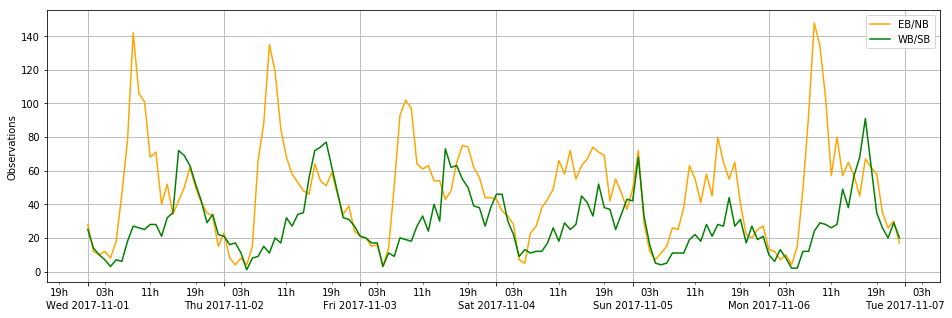

DT-0129. Jarvis-NB_King-to-Queen / DT-0126. Jarvis-SB_Queen-to-King


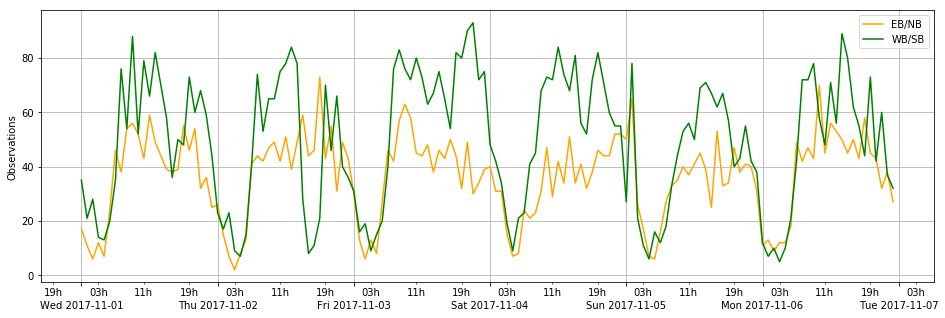

DT-0005. Dundas-EB_Roncesvalles-to-Dufferin / DT-0018. Dundas-WB_Dufferin-to-Roncesvalles


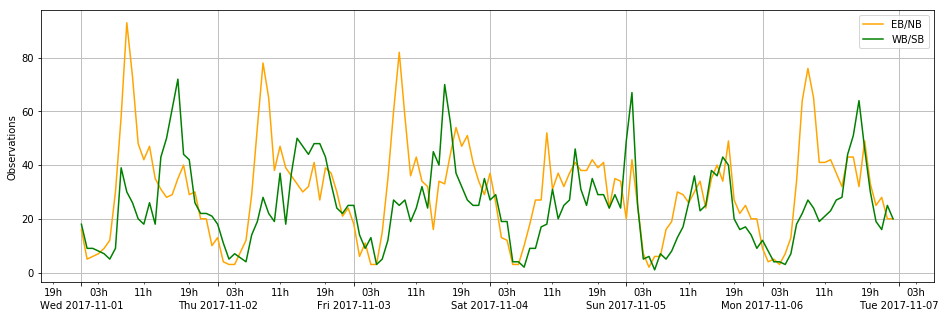

DT-0056. King-EB_Jarvis-to-Parliament / DT-0059. King-WB_Parliament-to-Jarvis


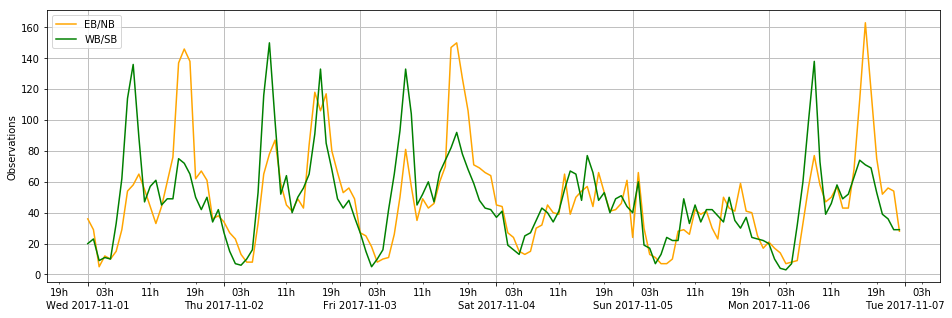

DT-0130. Jarvis-NB_Queen-to-Dundas / DT-0125. Jarvis-SB_Dundas-to-Queen


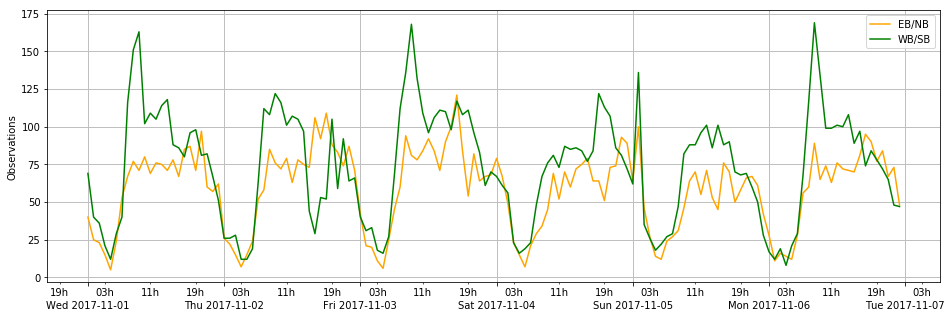

DT-0026. Queen-EB_Jarvis-to-Parliament / DT-0029. Queen-WB_Parliament-to-Jarvis


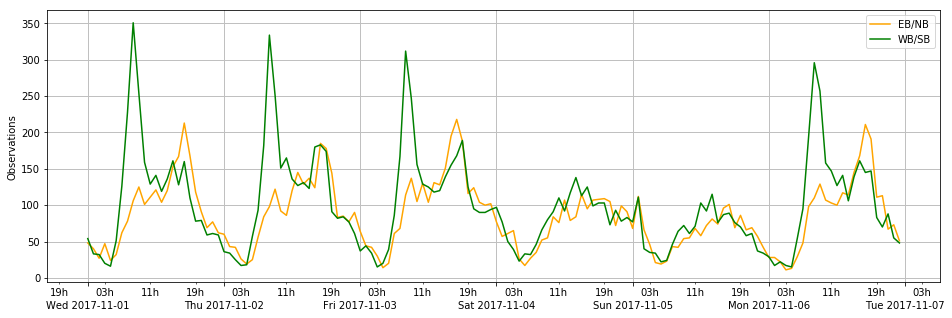

DT-0074. Front-EB_Jarvis-to-Parliament / DT-0075. Front-WB_Parliament-to-Jarvis


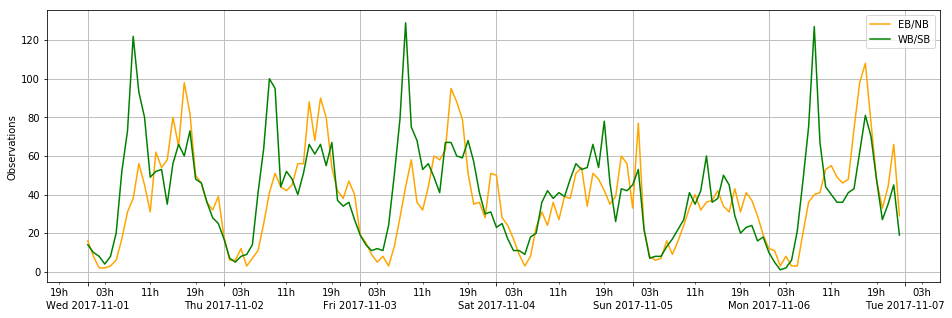

DT-0137. Parliament-NB_Queen-to-Dundas / DT-0132. Parliament-SB_Dundas-to-Queen


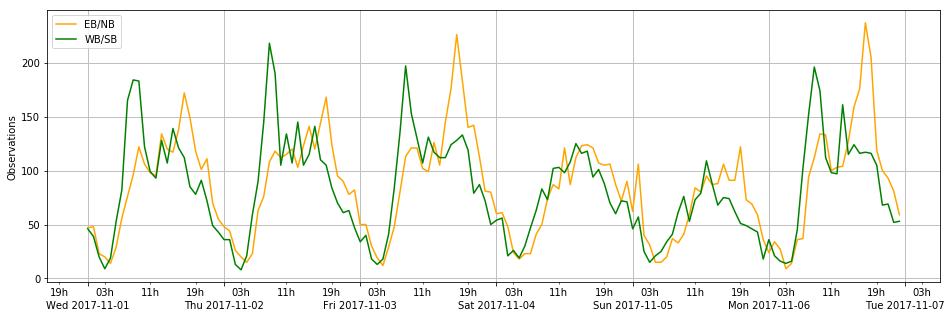

DT-0024. Queen-EB_University-to-Yonge / DT-0031. Queen-WB_Yonge-to-University


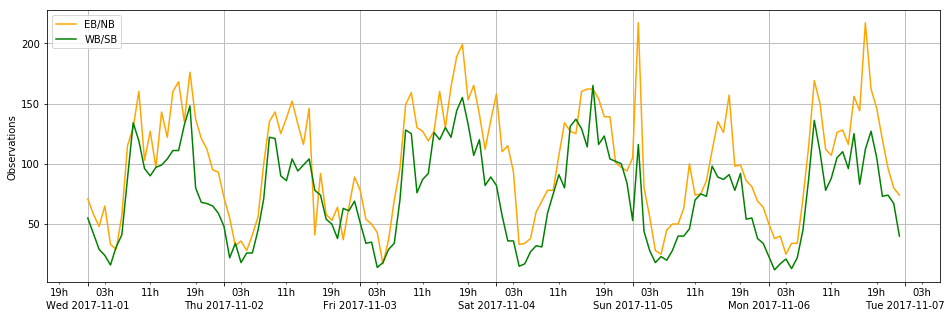

DT-0080. FortYork/Bremner-EB_Spadina-to-York / DT-0081. FortYork/Bremner-WB_York-to-Spadina


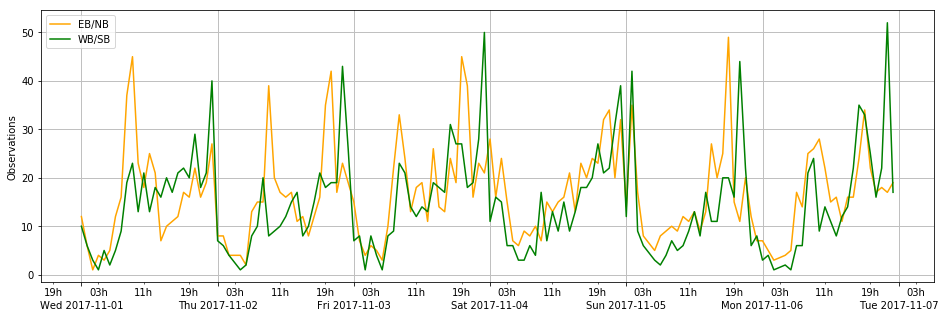

DT-0027. Queen-EB_Parliament-to-Broadview / DT-0028. Queen-WB_Broadview-to-Parliament


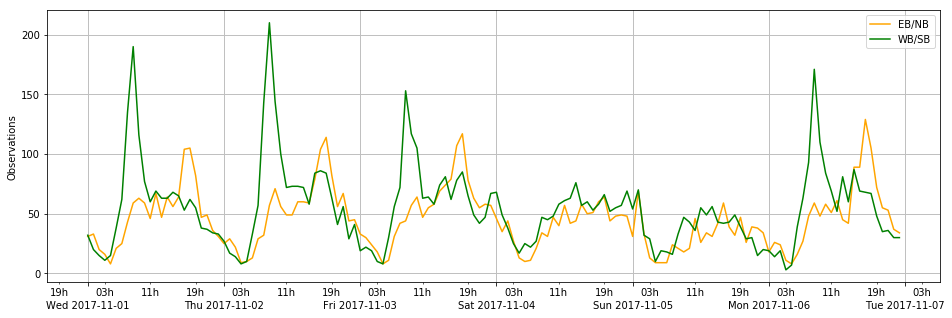

DT-0020. Queen-EB_Dufferin-to-Strachan / DT-0035. Queen-WB_Strachan-to-Dufferin


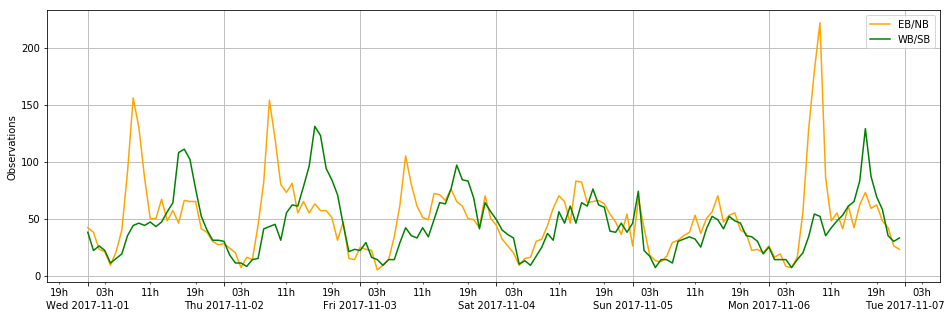

DT-0084. Roncesvalles-NB_Queen-to-Dundas / DT-0083. Roncesvalles-SB_Dundas-to-Queen


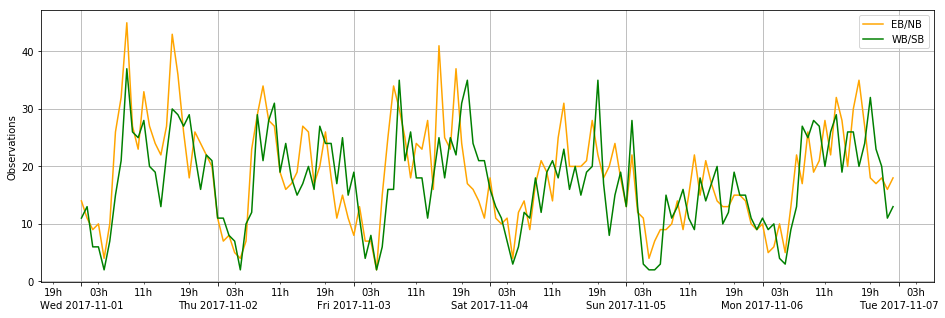

DT-0051. King-EB_Strachan-to-Bathurst / DT-0064. King-WB_Bathurst-to-Strachan


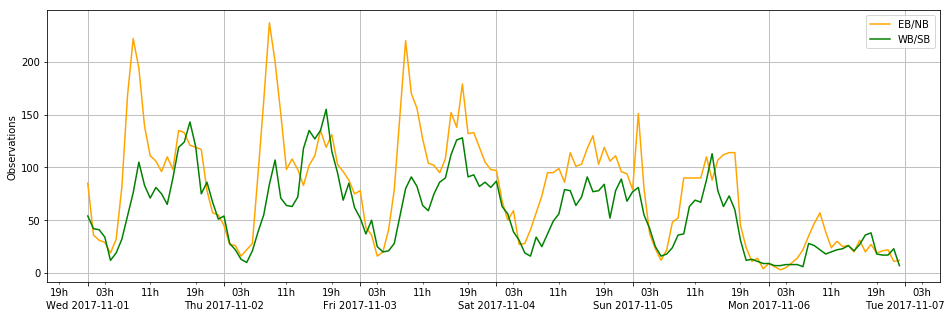

DT-0019. Queen-EB_Roncesvalles-to-Dufferin / DT-0036. Queen-WB_Dufferin-to-Roncesvalles


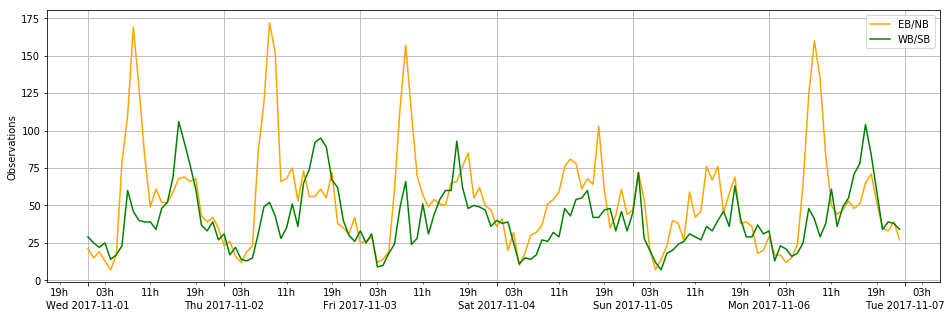

DT-0049. King-EB_Roncesvalles-to-Dufferin / DT-0066. King-WB_Dufferin-to-Roncesvalles


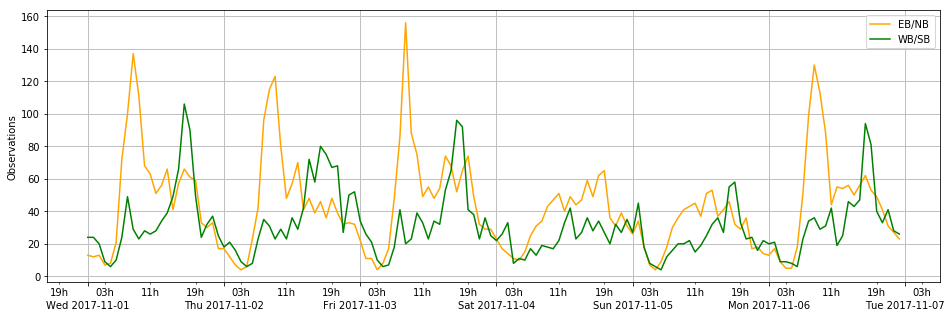

DT-0021. Queen-EB_Strachan-to-Bathurst / DT-0034. Queen-WB_Bathurst-to-Strachan


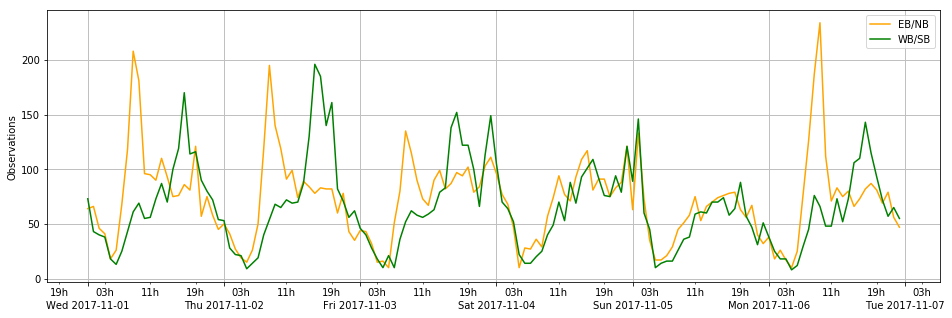

DT-0107. Spadina-NB_King-to-Queen / DT-0102. Spadina-SB_Queen-to-King


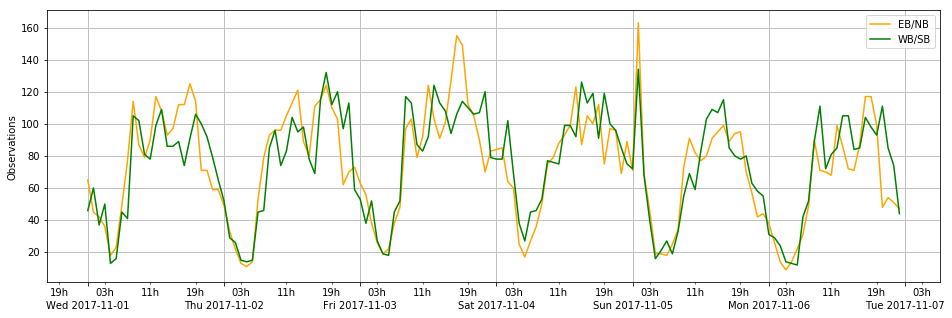

DT-0135. Parliament-NB_Front-to-King / DT-0134. Parliament-SB_King-to-Front


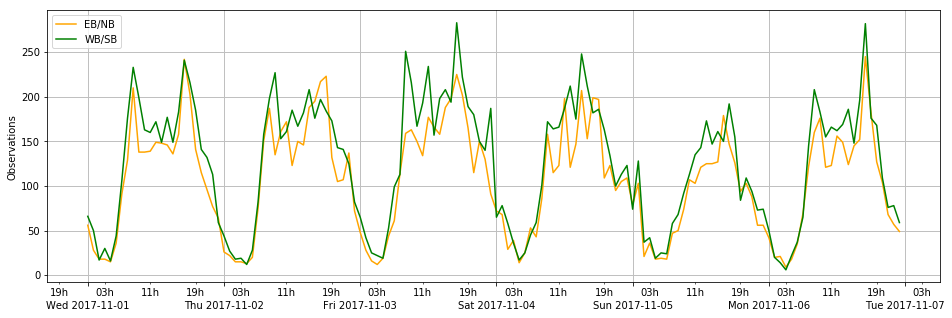

DT-0128. Jarvis-NB_Front-to-King / DT-0127. Jarvis-SB_King-to-Front


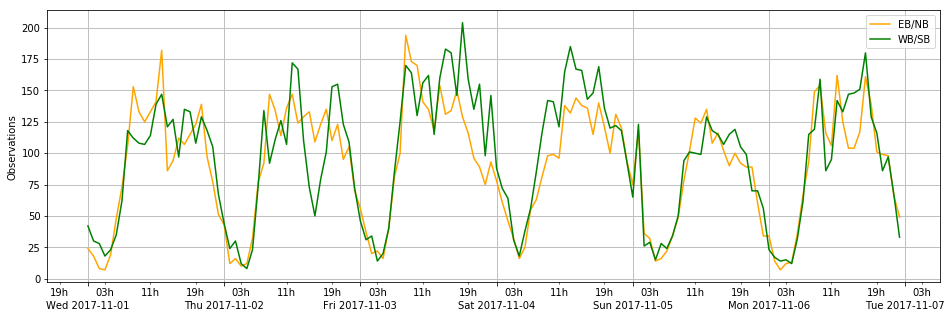

DT-0050. King-EB_Dufferin-to-Strachan / DT-0065. King-WB_Strachan-to-Dufferin


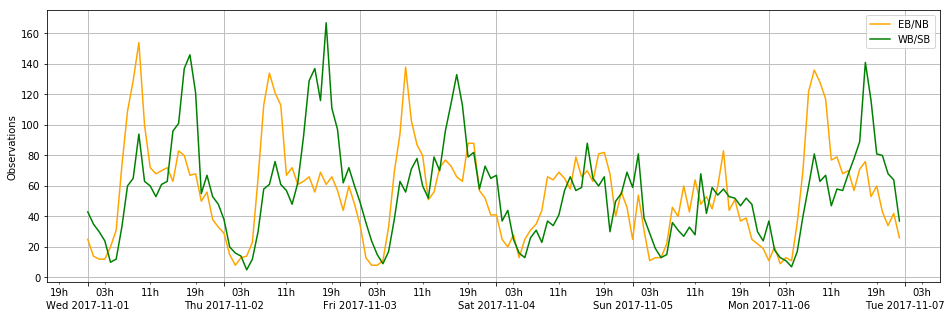

In [4]:
for i in range(len(routes)):
    print(ebnb_route[i] + " / " + wbsb_route[i])
    sql = pg.SQL('''CREATE OR REPLACE TEMP VIEW wbsb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {wbsb_route} \
                    AND datetime_bin < '2017-11-07' AND datetime_bin >= '2017-11-01' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    CREATE OR REPLACE TEMP VIEW ebnb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {ebnb_route} \
                    AND datetime_bin < '2017-11-07' AND datetime_bin >= '2017-11-01' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    SELECT wbsb.datetime_bin datetime_bin, wbsb.obs wbsb_obs, ebnb.obs ebnb_obs
                    FROM wbsb \
                    INNER JOIN ebnb ON wbsb.datetime_bin = ebnb.datetime_bin \
                    ORDER BY datetime_bin;
        ''').format(ebnb_route = pg.Literal(ebnb_route[i]), wbsb_route = pg.Literal(wbsb_route[i]))
    route_obs = pandasql.read_sql(sql, con)
    fig, ax = plt.subplots(1, 1, figsize=(16,5))
    ax.grid(color='silver', linestyle='-', linewidth=1)
    ebnb_line = ax.plot(route_obs.datetime_bin, route_obs.ebnb_obs, color='orange')
    wbsb_line = ax.plot(route_obs.datetime_bin, route_obs.wbsb_obs, color='green')
    ax.set_ylabel('Observations')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = [0, 1, 2, 3, 4, 5, 6]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%a %Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval = 8))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Hh'))
    ax.legend((ebnb_line[0], wbsb_line[0]), ('EB/NB', 'WB/SB'))
    plt.show()

Majority of the routes show non-matching EB/NB and WB/SB observations where one direction would have a significantly higher number of observations than the other. Extreme cases such as 'Front - Spadina to University' and 'University - Queen to Dundas' show results where observations are consistently higher for one direction. For 'University - Queen to Dundas' the NB direction observations briefly surpasses the SB direction observations during the AM peak periods. This is then met with a  number of SB direction observations almost doubles the opposing observations during the PM peak period. This may show a bias towards the stopped traffic of the SB side in terms of number of observations while only a fraction of the actual number of observations for the NB side is taken. A similar graph with the the same results but in reverse is demonstrated by 'Dundas - Spadina to University'.

### Looking at Sensor Locations
#### Top 10 Imbalanced Routes (Considering WiFi)

|Segment|Route Name|First Sensor|First Sensor Position|Second Sensor|Second Sensor Location|Bias Direction|
|---|---|---|---|---|---|---|
|Front Spadina-University|DT-0071. Front-EB_Spadina-to-University|FR_UN|SE|FR_SP|SW|EB|
||DT-0077. Front-WB_University-to-Spadina|FR_UN|SE|FR_SP|SW|EB|
|University Queen-Dundas|DT-0117. University-NB_Queen-to-Dundas|DU_UN|SW|QU_UN|NW|SB|
||DT-0110. University-SB_Dundas-to-Queen|QU_UN|NW|DU_UN|SW|SB|
|King Spadina-University|DT-0053. King-EB_Spadina-to-University|KN_UN|SW|KN_SP|SW|EB|
||DT-0062. King-WB_University-to-Spadina|KN_UN|SW|KN_SP|SW|EB|
|Dundas Spadina-University|DT-0008. Dundas-EB_Spadina-to-University|DU_UN|SW|DU_SP|SW|EB|
||DT-0015. Dundas-WB_University-to-Spadina|DU_SP|SW|DU_UN|SW|EB|
|King University-Yonge|DT-0054. King-EB_University-to-Yonge|KN_YO|SW|KN_UN|SW|EB|
||DT-0061. King-WB_Yonge-to-University|KN_UN|SW|KN_YO|SW|EB|
|Dundas Bathurst-Spadina|DT-0007. Dundas-EB_Bathurst-to-Spadina|DU_BA|SW|DU_SP|SW|EB|
||DT-0016. Dundas-WB_Spadina-to-Bathurst|DU_BA|SW|DU_SP|SW|EB|
|Dundas Jarvis-Parliament|DT-0011. Dundas-EB_Jarvis-to-Parliament|DU_PA|SW|DU_JA|NW|EB|
||DT-0012. Dundas-WB_Parliament-to-Jarvis|DU_JA|NW|DU_PA|SW|EB|
|Front Bathurst-Spadina|DT-0070. Front-EB_Bathurst-to-Spadina|FR_BA|SE|FR_SP|SW|EB|
||DT-0078. Front-WB_Spadina-to-Bathurst|FR_SP|SW|FR_BA|SE|EB|
|Dundas Dufferin-Bathurst|DT-0006. Dundas-EB_Dufferin-to-Bathurst|DU_DF|SW|DU_BA|SW|EB|
||DT-0017. Dundas-WB_Bathurst-to-Dufferin|DU_BA|SW|DU_DF|SW|EB|
|University Dundas-College|DT-0118. University-NB_Dundas-to-College|CO_UN|SW|DU_UN|SW|SB|
||DT-0109. University-SB_College-to-Dundas|CO_UN|SW|DU_UN|SW|SB|

#### Bottom 5 Imbalanced Routes (Considering WiFi)
|Segment|Route Name|First Sensor|First Sensor Position|Second Sensor|Second Sensor Location|Bias Direction|
|---|---|---|---|---|---|---|
|King Dufferin-Strachan|DT-0050. King-EB_Dufferin-to-Strachan|KN_DF|SW|KN_ST|NE|EB|
||DT-0065. King-WB_Strachan-to-Dufferin|KN_DF|SW|KN_ST|NE|EB|
|Jarvis Front-King|DT-0128. Jarvis-NB_Front-to-King|KN_JA|NW|FR_JA|SE|SB|
||DT-0127. Jarvis-SB_King-to-Front|FR_JA|SE|KN_JA|NW|SB|
|York Bremner-Front|DT-0114. York-NB_Bremner-to-Front|FR_UN|SE|FB_YK|SW|NB|
||DT-0113. York-SB_Front-to-Bremner|FB_YK|SW|FR_UN|SE|NB|
|Spadina King-Queen|DT-0107. Spadina-NB_King-to-Queen|KN_SP|SW|QU_SP|NW|SB|
||DT-0102. Spadina-SB_Queen-to-King|QU_SP|NW|KN_SP|SW|SB|
|Queen Yonge-Jarvis|DT-0025. Queen-EB_Yonge-to-Jarvis|QU_JA|NW|QU_YO|SW|EB|
||DT-0030. Queen-WB_Jarvis-to-Yonge|QU_YO|SW|QU_JA|NW|EB|

Note: Includes WiFi Observations

Inspecting the data shows that placement of sensors may cause some bias in the data. In many cases among the top 10 unbalanced routes, pairs of sensors are placed in the same location in each location (often SW corner). As a result of this placement, there is a bias towards east bound traffic. The affect is minimized when pairs of sensors have a different placement location from their counterpart as shown by the bottom 5 imbalanced routes.

Special cases among the top 10 imbalanced include 'Front Spadina-University' and 'Front Bathurst-Spadina'. Both these routes are special since their sensor placement is not the same across the pair unlike the other imbalanced routes. In addition, Spadina Ave is a major arterial with 6 lanes across in addition to 2 street car lanes which make the intersection very wide. As a result, not all observations may be picked up by the sensor and is likely to be biased. Both routes also have a 3 way turn intersection which may cause bias due to their layout. 'Front Spadina-University' in the Front/University intersection is also curved which may cause significant bias and may be responsible for being the most imbalanced route.

Another special case is 'University Queen-Dundas' and 'University Dundas-College' which are both N/S bound segments. They are likely to be biased due to the wider intersections caused by University being 8 lanes wide in addition to a very large middle island which could cause the same affect as the sensors on Spadina.

Something is odd where routes on Spadina are not as imbalanced as the routes on University. I may be possible that sensors on Spadina can handle N/S bound traffic but sensors on University cannot since its considerably wider. Looking at sensors on University vs Spadina, the positions of each sensor are the same when parallel.

#### Top 10 Imbalanced Routes (only BT)
|Segment|First Sensor|First Sensor Position|Second Sensor|Second Sensor Location|Bias Direction|
|---|---|---|---|---|---|
|University Queen-Dundas|DU_UN|SW|QU_UN|NW|SB
||QU_UN|NW|DU_UN|SW|SB
|Front Spadina-University|FR_UN|SE|FR_SP|SW|EB
||FR_UN|SE|FR_SP|SW|EB
|University Dundas-College|CO_UN|SW|DU_UN|SW|EB
||CO_UN|SW|DU_UN|SW|EB
|University King-Queen|KN_UN|SW|QU_UN|NW|SB
||KN_UN|SW|QU_UN|NW|SB
|Front University-Yonge|FR_UN|SE|FR_YO|NW|EB
||FR_UN|SE|FR_YO|NW|EB
|Dundas Yonge-Jarvis|DU_YO|NW|DU_JA|NW|EB
||DU_YO|NW|DU_JA|NW|EB
|Dundas Jarvis-Parliament|DU_JA|NW|DU_PA|NW|EB
||DU_JA|NW|DU_PA|NW|EB
|Dundas University-Yonge|DU_UN|SW|DU_YO|NW|EB
||DU_UN|SW|DU_YO|NW|EB
|Stratchan King-Queen|QU_ST|NE|KN_ST|NE|NB
||QU_ST|NE|KN_ST|NE|NB
|Front Bathurst-Spadina|FR_BA|SE|FR_SP|SW|EB
||FR_BA|SE|FR_SP|SW|EB

It appears that the same problem occurs even when only BT observations are considered. This shows that a bias is likely to occur when sensors share the same position/side when in pairs.

### Looking the Direction Speed Distribution of each Route

In [5]:
# One way streets are ommited.
sql = pg.SQL('''SELECT DISTINCT segment FROM ryu4.bt_segments WHERE direction IN ('EB', 'WB')
AND segment NOT SIMILAR TO '(Richmond|Adelaide|Wellington|Eastern|Front/|Front Yonge)%' ORDER BY segment''')
ebwb_segments = pandasql.read_sql(sql, con)

Speed Distribution of East/West Routes


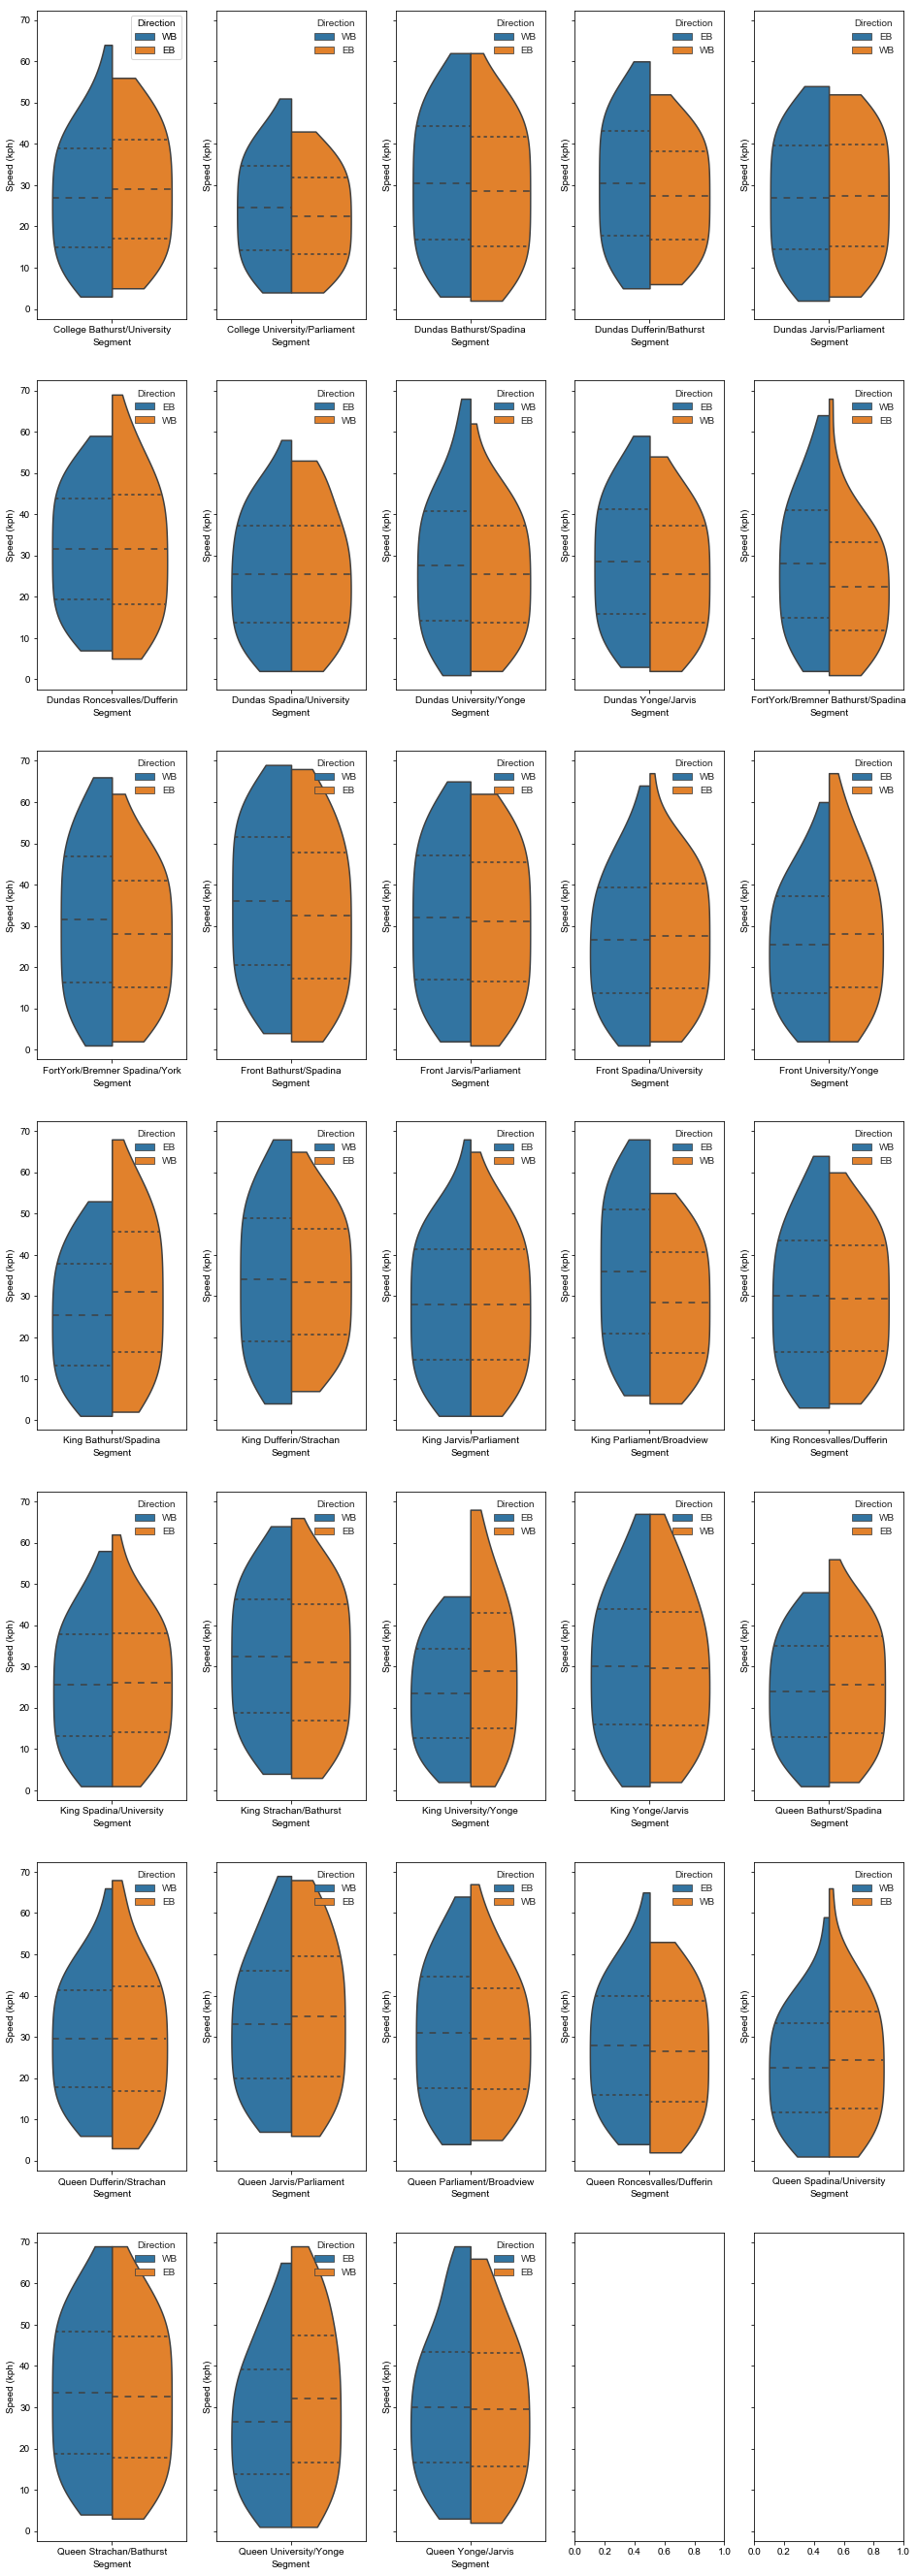

In [6]:
fig, ax = plt.subplots(nrows=7, ncols=5, sharey= True, figsize=(16,48))
row, col = 0, 0
print("Speed Distribution of East/West Routes")
for i in range(len(ebwb_segments)):
    segment = ebwb_segments.segment[i]
    sql = pg.SQL('''SELECT seg.segment AS "Segment", trunc(3.6*seg.length_m/bt.travel_time) AS "Speed (kph)",
            seg.direction AS "Direction"
            FROM ryu4.aggr_15min_bt bt
            JOIN ryu4.bt_segments seg ON seg.analysis_id = bt.analysis_id
            WHERE bt.travel_time > 0 AND seg.direction IN ('EB', 'WB') AND seg.segment = {segment}
            GROUP BY segment, "Speed (kph)", seg.direction;''').format(segment = pg.Literal(segment))
    bt_speed_distrib = pandasql.read_sql(sql, con)
    sns.violinplot(ax=ax[row, col], x="Segment", y="Speed (kph)", hue="Direction", inner="quart",
               data = bt_speed_distrib[(bt_speed_distrib["Speed (kph)"] < 70) & (bt_speed_distrib["Speed (kph)"] > 0)],
               split=True, ylim=[0,70], cut=0)
    sns.set_style("darkgrid")
    col += 1
    if col%5 == 0: 
        row += 1
        col  = 0

Majority of E/W routes appear to have an equal distribution of speeds among east bound and west bound road segments. There are a few cases where the distribution is not equal. These cases are:
- Fort York/Bremner Bathurst/Spadina
- Fort York/Bremner Spadina/York
- King Bathurst/Spadina
- King Parliament/Broadview
- King University/Yonge
- Queen University/Yonge
- Queen Yonge/Jarvis

In [7]:
sql = pg.SQL('''SELECT DISTINCT segment FROM ryu4.bt_segments WHERE direction IN ('NB', 'SB') ORDER BY segment''')
nbsb_segments = pandasql.read_sql(sql, con)

Speed Distribution of North/South Routes


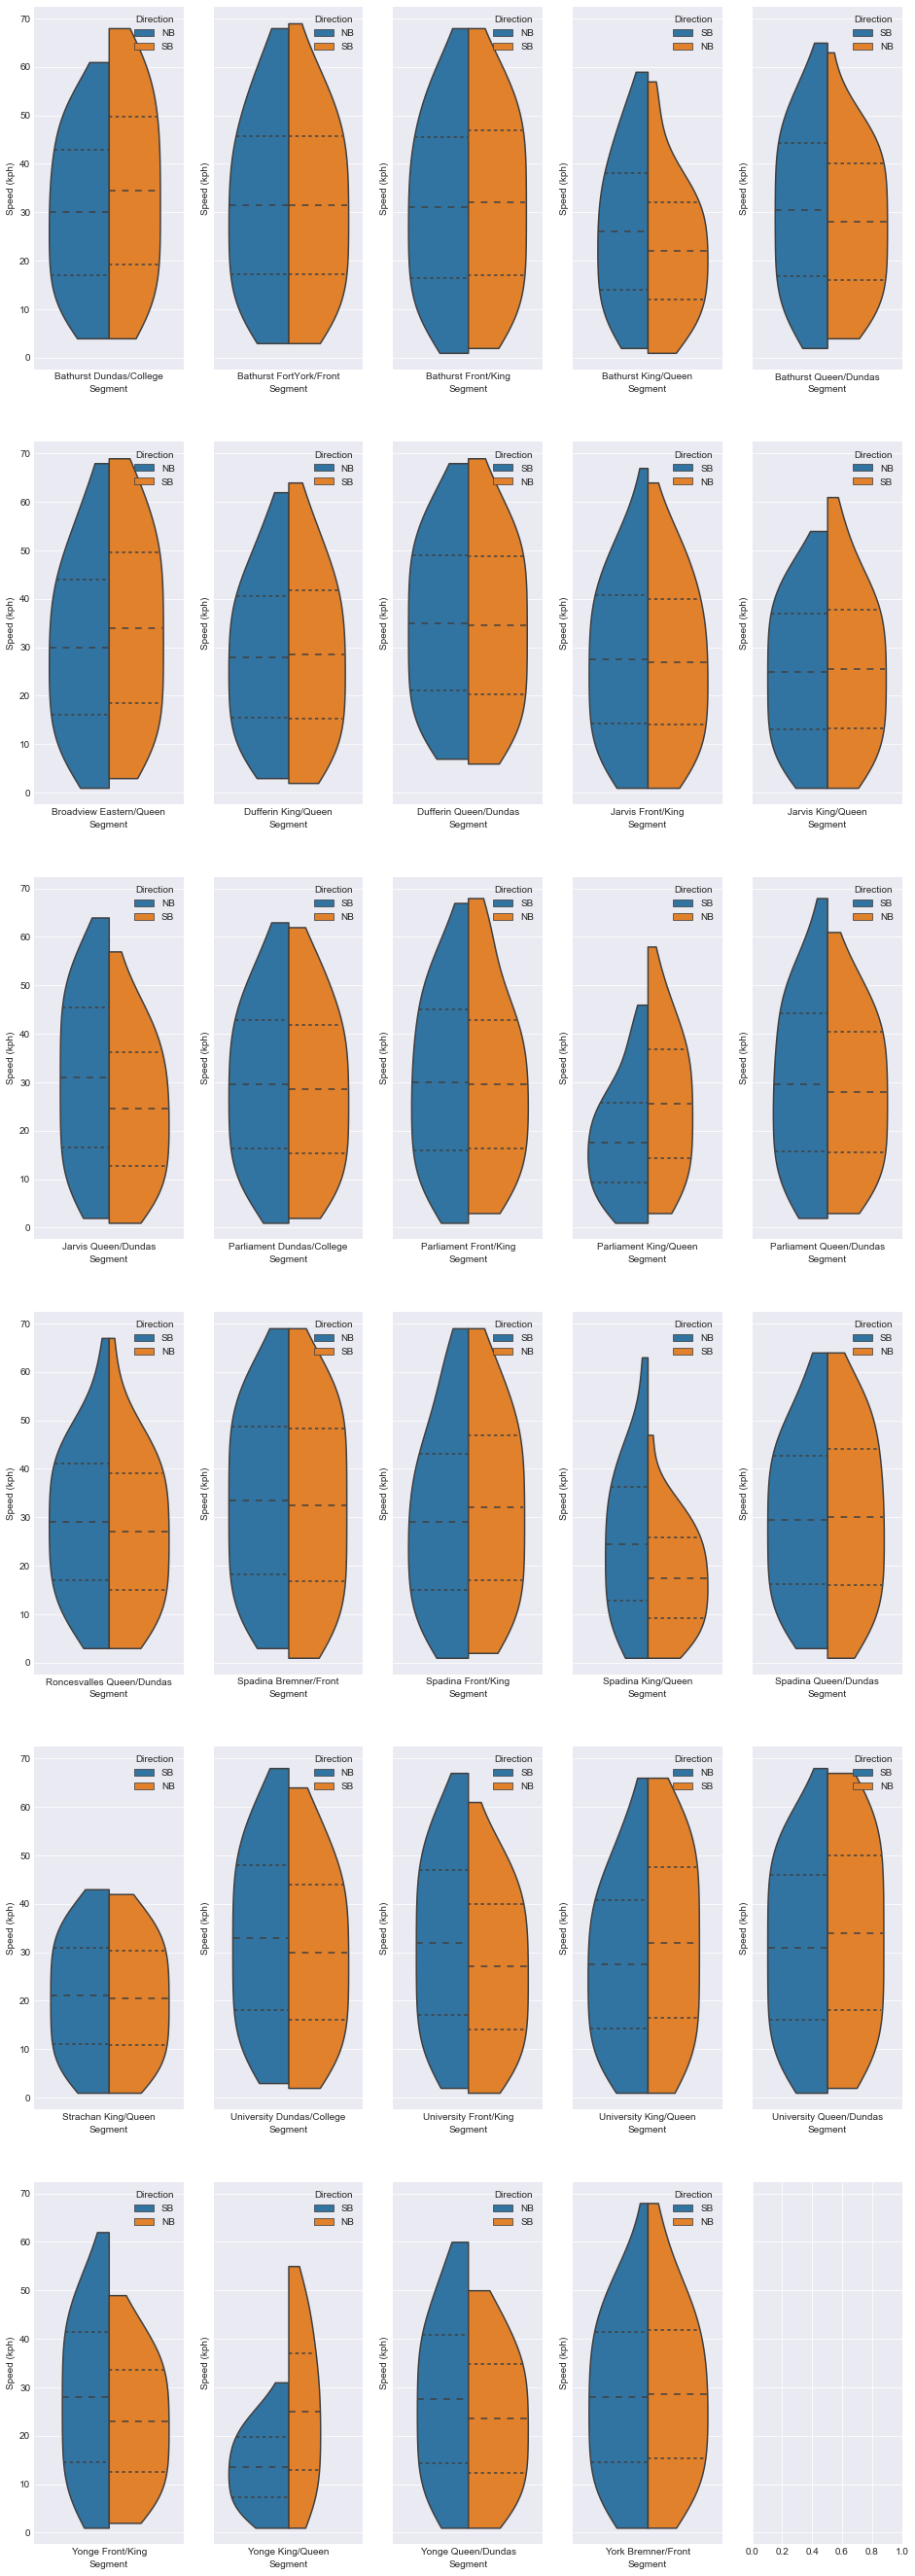

In [8]:
fig, ax = plt.subplots(nrows=6, ncols=5, sharey= True, figsize=(16,48))
row, col = 0, 0
print("Speed Distribution of North/South Routes")
for i in range(len(nbsb_segments)):
    segment = nbsb_segments.segment[i]
    sql = pg.SQL('''SELECT seg.segment AS "Segment", trunc(3.6*seg.length_m/bt.travel_time) AS "Speed (kph)",
            seg.direction AS "Direction"
            FROM ryu4.aggr_15min_bt bt
            JOIN ryu4.bt_segments seg ON seg.analysis_id = bt.analysis_id
            WHERE bt.travel_time > 0 AND seg.direction IN ('NB', 'SB') AND seg.segment = {segment}
            GROUP BY segment, "Speed (kph)", seg.direction;''').format(segment = pg.Literal(segment))
    bt_speed_distrib = pandasql.read_sql(sql, con)
    sns.violinplot(ax=ax[row, col], x="Segment", y="Speed (kph)", hue="Direction", inner="quart",
               data = bt_speed_distrib[(bt_speed_distrib["Speed (kph)"]< 70) & (bt_speed_distrib["Speed (kph)"] > 0)],
               split=True, ylim=[0,70], cut=0)
    sns.set_style("darkgrid")
    col += 1
    if col%5 == 0: 
        row += 1
        col  = 0

Alot more routes appear to be imbalanced for N/S routes. The most notable imbalanced routes include:
- Bathurst King/Queen
- Jarvis Queen/Dundas
- Parliament King/Queen
- University Front/King
- University King/Queen
- Yonge Front/King
- Yonge King/Queen
- Yonge Queen/Dundas